# Versión para diapositivas

La idea de este notebook es hacer algunas visualizaciones o rehacer tablas para las diapositivas. Si para hacer algo tenemos que correr mucho código, me parece buena regla descartarlo. A partir de la sección 3 es el TP2.

# 0. Importación de Librerías y Configuraciones Iniciales

In [14]:
# Importación de librerías
import pandas as pd
import numpy as np

from sklearn.impute import KNNImputer

from tp2_utils import *

from missingno import heatmap
import seaborn as sns

# Configuracion de pandas

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

tp2_utils contiene funciones útiles para este trabajo, las que, para limpieza de este notebook, se prefirió mantener en una librería a importar.

En los submódulos de la librería podemos encontrar:
- df_categorical_transformations_utils y df_numerical_transformations: transformacions básicas al dataset identificadas en el trabajo anterior (con algunas modificaciones, como se detalla abajo) para la curación de los datos. Estas son usadas en las secciones 3 y 4.
- variables_classification: Contiene claseVariablesClassification, que permite acceder a la clasificación de las variables realizada en el TP1.
- df_exploration_utils: Funciones útiles para explorar los datos, usadas para explicar algunas decisiones.
- df_rows_and_columns_remove: Funciones para la eliminación de filas y columnas nulas o consideradas irrelevantes.
- data_split_and_imputation: Funciones para dividir los datasets en train y test y explorar imputaciones.

# 2. Importación de base de datos original

In [2]:
# Cargar el dataset

url = "https://raw.githubusercontent.com/MaricelSantos/Mentoria--Diplodatos-2025/main/Conexiones_Transparentes.csv"
df = pd.read_csv(url)

# 2 bis. Rehacemos algunas cositas para que queden más prolijas

**Tabla de visualización de calidad original de los datos**

In [6]:
# Patrón para valores como <n
patron = re.compile(r'^<\d+\.?\d*$')  # Acepta <3, <3.5, etc.

numericas = VariablesClassification().numericas

print("Calidad de los datos sin ningún preprocesamiento.")
print("Porcentaje de:")
print("Columna\t\t\t\tCeros\tNo numéricos\tCon forma '<x'\tFaltantes")
print("______________________________________________________________________________________")
for col in numericas:
    # Intentar convertir a numérico
    valores_numericos = pd.to_numeric(df[col], errors='coerce')
    no_numericos = df[col][valores_numericos.isna() & df[col].notna()]
    
    # Contar cantidad de valores ...
    cantidad_no_numericos = len(no_numericos) # no numéricos
    cantidad_ceros = (df[col] == 0).sum() # iguales a cero
    #vacios = df[col].str.strip().eq("").sum() # Vacíos -carácter "" o algún tipo de espacio-
    nulos = df[col].isnull().sum() # Nulos
    if cantidad_no_numericos != 0:
        valores_menor_que = no_numericos.apply(lambda x: bool(patron.match(str(x)))).sum() # Valores de forma '<x'
    else:
        valores_menor_que = 0
    
    # Cálculo de porcentajes
    total = len(df)
    porc_ceros = cantidad_ceros*100/total
    porc_no_numericos = (cantidad_no_numericos-valores_menor_que)*100/total
    porc_menores_que = valores_menor_que*100/total
    porc_nulos = nulos*100/total
    #porc_vacios = vacios*100/total
    #print(f"{col:<{25}}\t{porc_ceros:5.2f}\t   {porc_no_numericos:5.2f}\t    {porc_menores_que:5.2f}\t{porc_nulos:5.2f}\t{porc_vacios:5.2f}")
    print(f"{col:<{25}}\t{porc_ceros:5.2f}\t   {porc_no_numericos:5.2f}\t    {porc_menores_que:5.2f}\t{porc_nulos:5.2f}")

Calidad de los datos sin ningún preprocesamiento.
Porcentaje de:
Columna				Ceros	No numéricos	Con forma '<x'	Faltantes
______________________________________________________________________________________
tem_agua                 	 0.00	   12.89	     0.00	 6.69
tem_aire                 	 0.00	   12.72	     0.00	 8.48
od                       	 0.00	   16.15	     0.00	 6.69
ph                       	 0.00	   20.23	     0.00	 7.50
colif_fecales_ufc_100ml  	 0.00	   14.36	     0.00	 6.85
escher_coli_ufc_100ml    	 0.00	   13.21	     0.00	 6.53
enteroc_ufc_100ml        	 0.00	   13.21	     0.00	 6.53
nitrato_mg_l             	 0.00	    8.97	     7.83	 6.53
nh4_mg_l                 	 0.00	    8.32	     7.34	 6.53
p_total_l_mg_l           	 0.00	   13.05	     2.45	 6.69
fosf_ortofos_mg_l        	 0.00	   20.39	     7.83	 6.53
dbo_mg_l                 	 0.00	   22.68	    15.82	 6.85
dqo_mg_l                 	 0.00	   19.41	    37.36	 6.36
turbiedad_ntu            	 0.00	    9.30	     3.92	 

**Tabla comparando tipo y porcentaje de valores faltantes antes y después de la corrección de las variables**

In [16]:
### Comparamos info general del dataset original y el corregido
# Cargamos el dataset obtenido del paso anterior, para evitar tener que volver a correr las celdas anteriores:
df10 = pd.read_csv('./aguas_limpieza_numericas_y_categoricas.csv', low_memory=False)

print("\tColumna\t\t\t\t\tTipo Orig\tFalt. Orig (%)\tTipo Corr.\tFalt. Corr. (%)")
print("_______________________________________________________________________________________________________________")
print("")
total = len(df)
for col in df.columns:
    # Tipo de datos de la columna
    tipo_dato_original = df[col].dtype
    tipo_dato_corregido = df10[col].dtype
    # Cantidad de datos no nulos
    no_nulos_orginal = df[col].count()
    no_nulos_corregido = df10[col].count()
    # Porcentaje de datos nulos
    nulos_orig = 100 - no_nulos_orginal*100/total
    nulos_corr = 100 - no_nulos_corregido*100/total
    print(f"\t{col[:26]:<{25}}\t\t  {str(tipo_dato_original):<{7}}\t  {nulos_orig:5.2f}\t\t {str(tipo_dato_corregido)[:8]:<{7}}\t   {nulos_corr:5.2f}")

	Columna					Tipo Orig	Falt. Orig (%)	Tipo Corr.	Falt. Corr. (%)
_______________________________________________________________________________________________________________

	orden                    		  float64	   3.92		 float64	    3.92
	sitios                   		  object 	   3.92		 object 	    3.92
	codigo                   		  object 	   0.00		 object 	    0.00
	fecha                    		  object 	   3.92		 object 	    7.18
	año                      		  object 	   6.53		 float64	    7.34
	campaña                  		  object 	   6.53		 object 	    7.34
	tem_agua                 		  object 	   6.69		 float64	   19.58
	tem_aire                 		  object 	   8.48		 float64	   21.21
	od                       		  object 	   6.69		 float64	   22.84
	ph                       		  object 	   7.50		 float64	   27.73
	olores                   		  object 	   6.36		 float64	   14.52
	color                    		  object 	   6.36		 float64	   14.52
	espumas                  		  object 	   6

**Matrices de correlación de valores faltantes**

<Axes: >

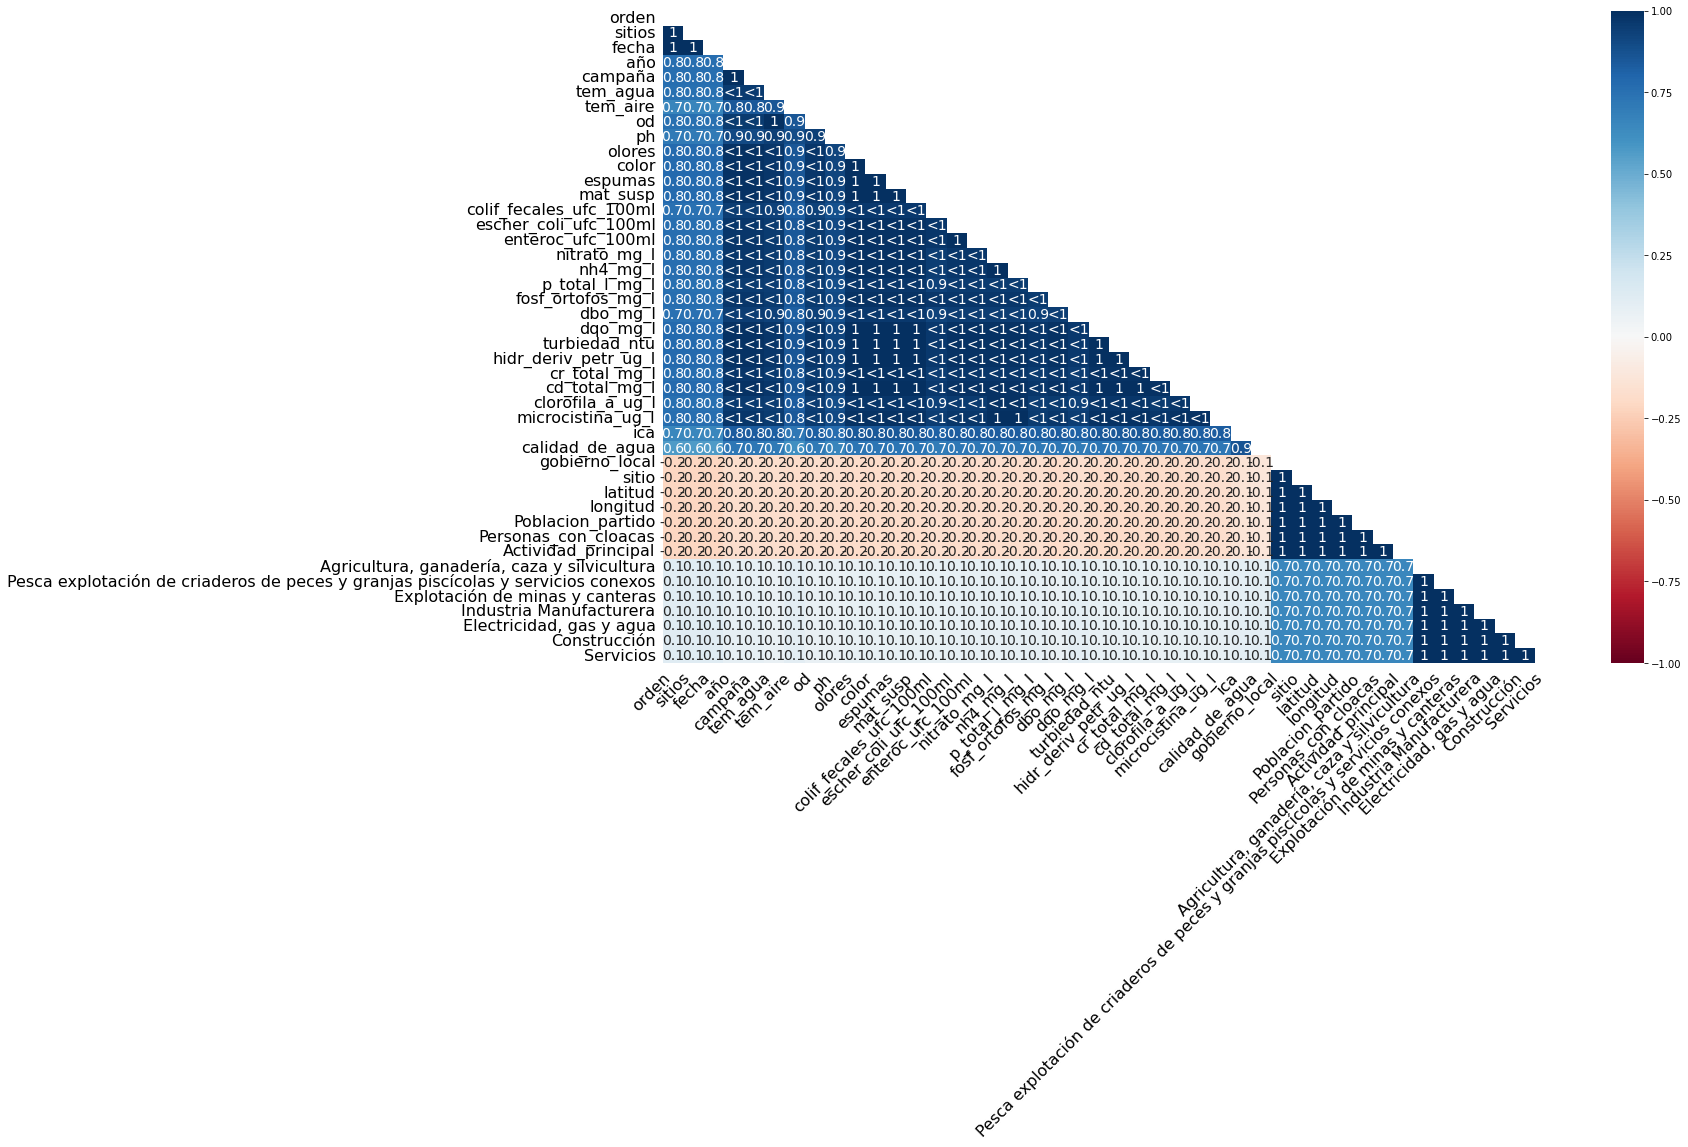

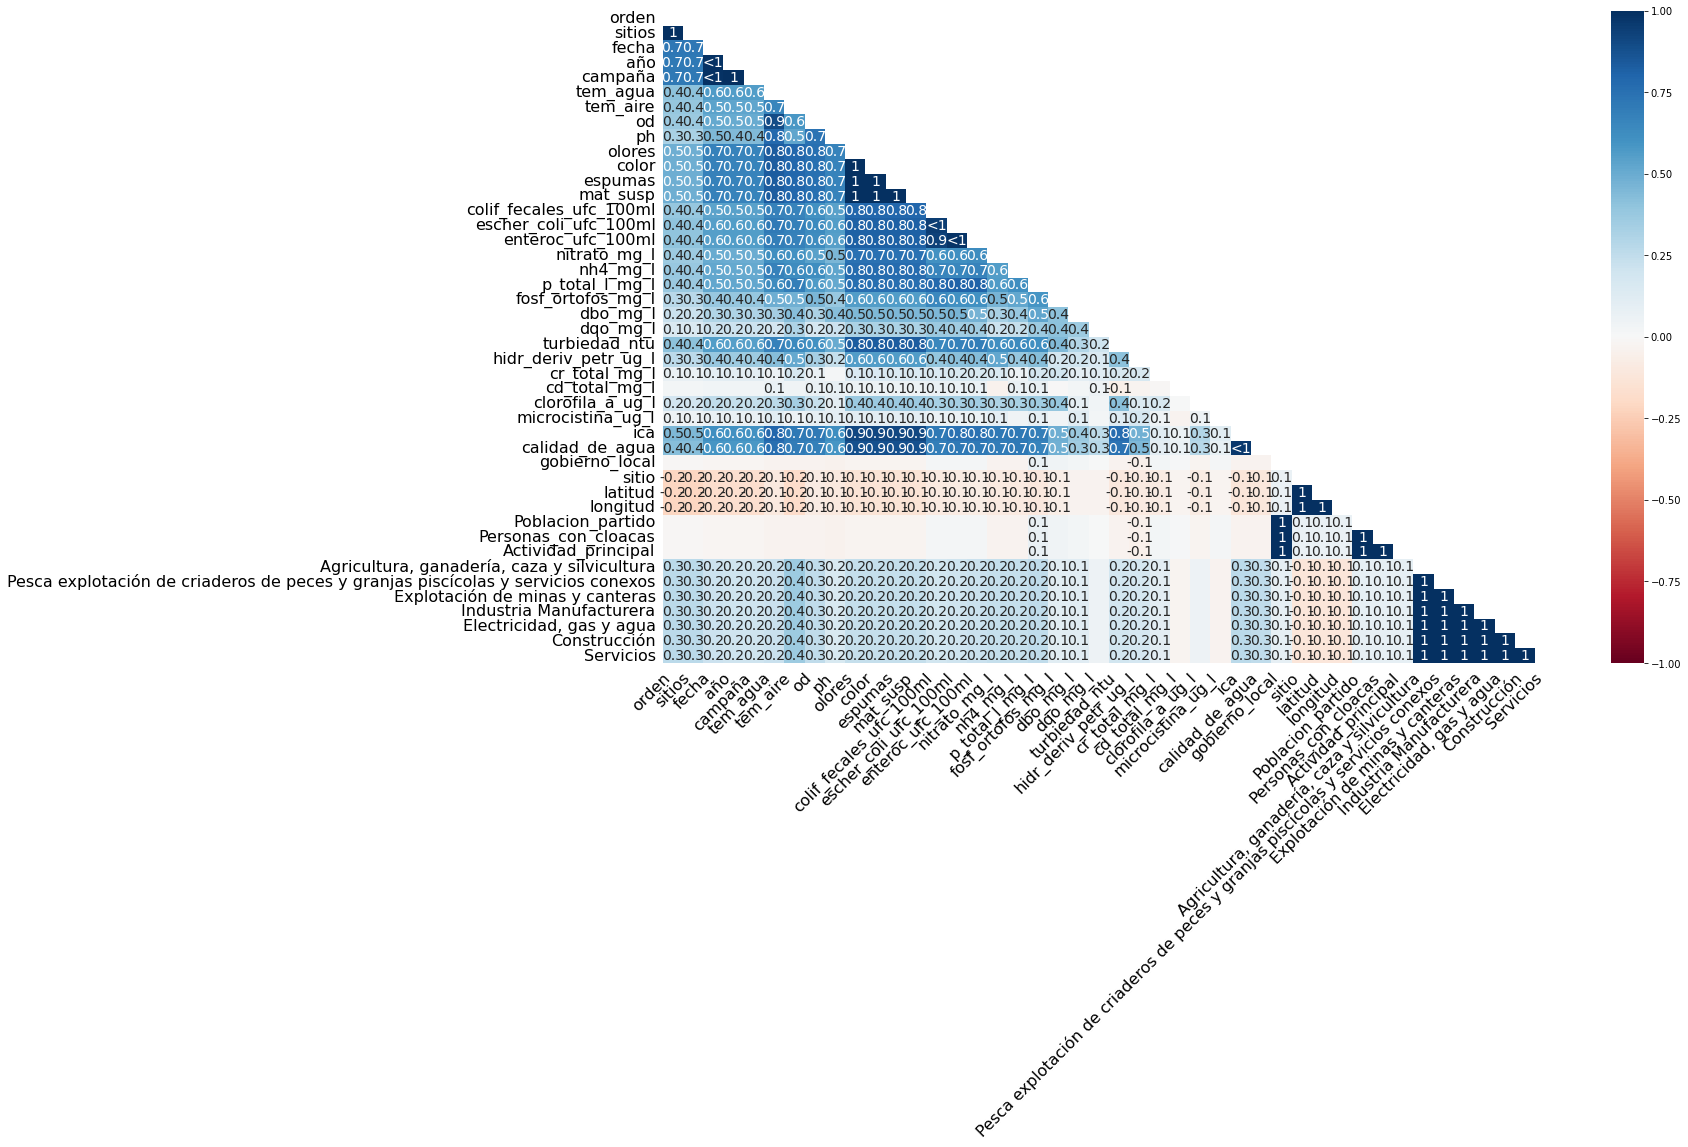

In [11]:
heatmap(df, "Correlación de presencia de datos faltantes en el dataset original")
heatmap(df10, "Correlación de presencia de datos faltantes en el dataset con variables corregidas")

**Matriz correlación del dataset completamente curado**

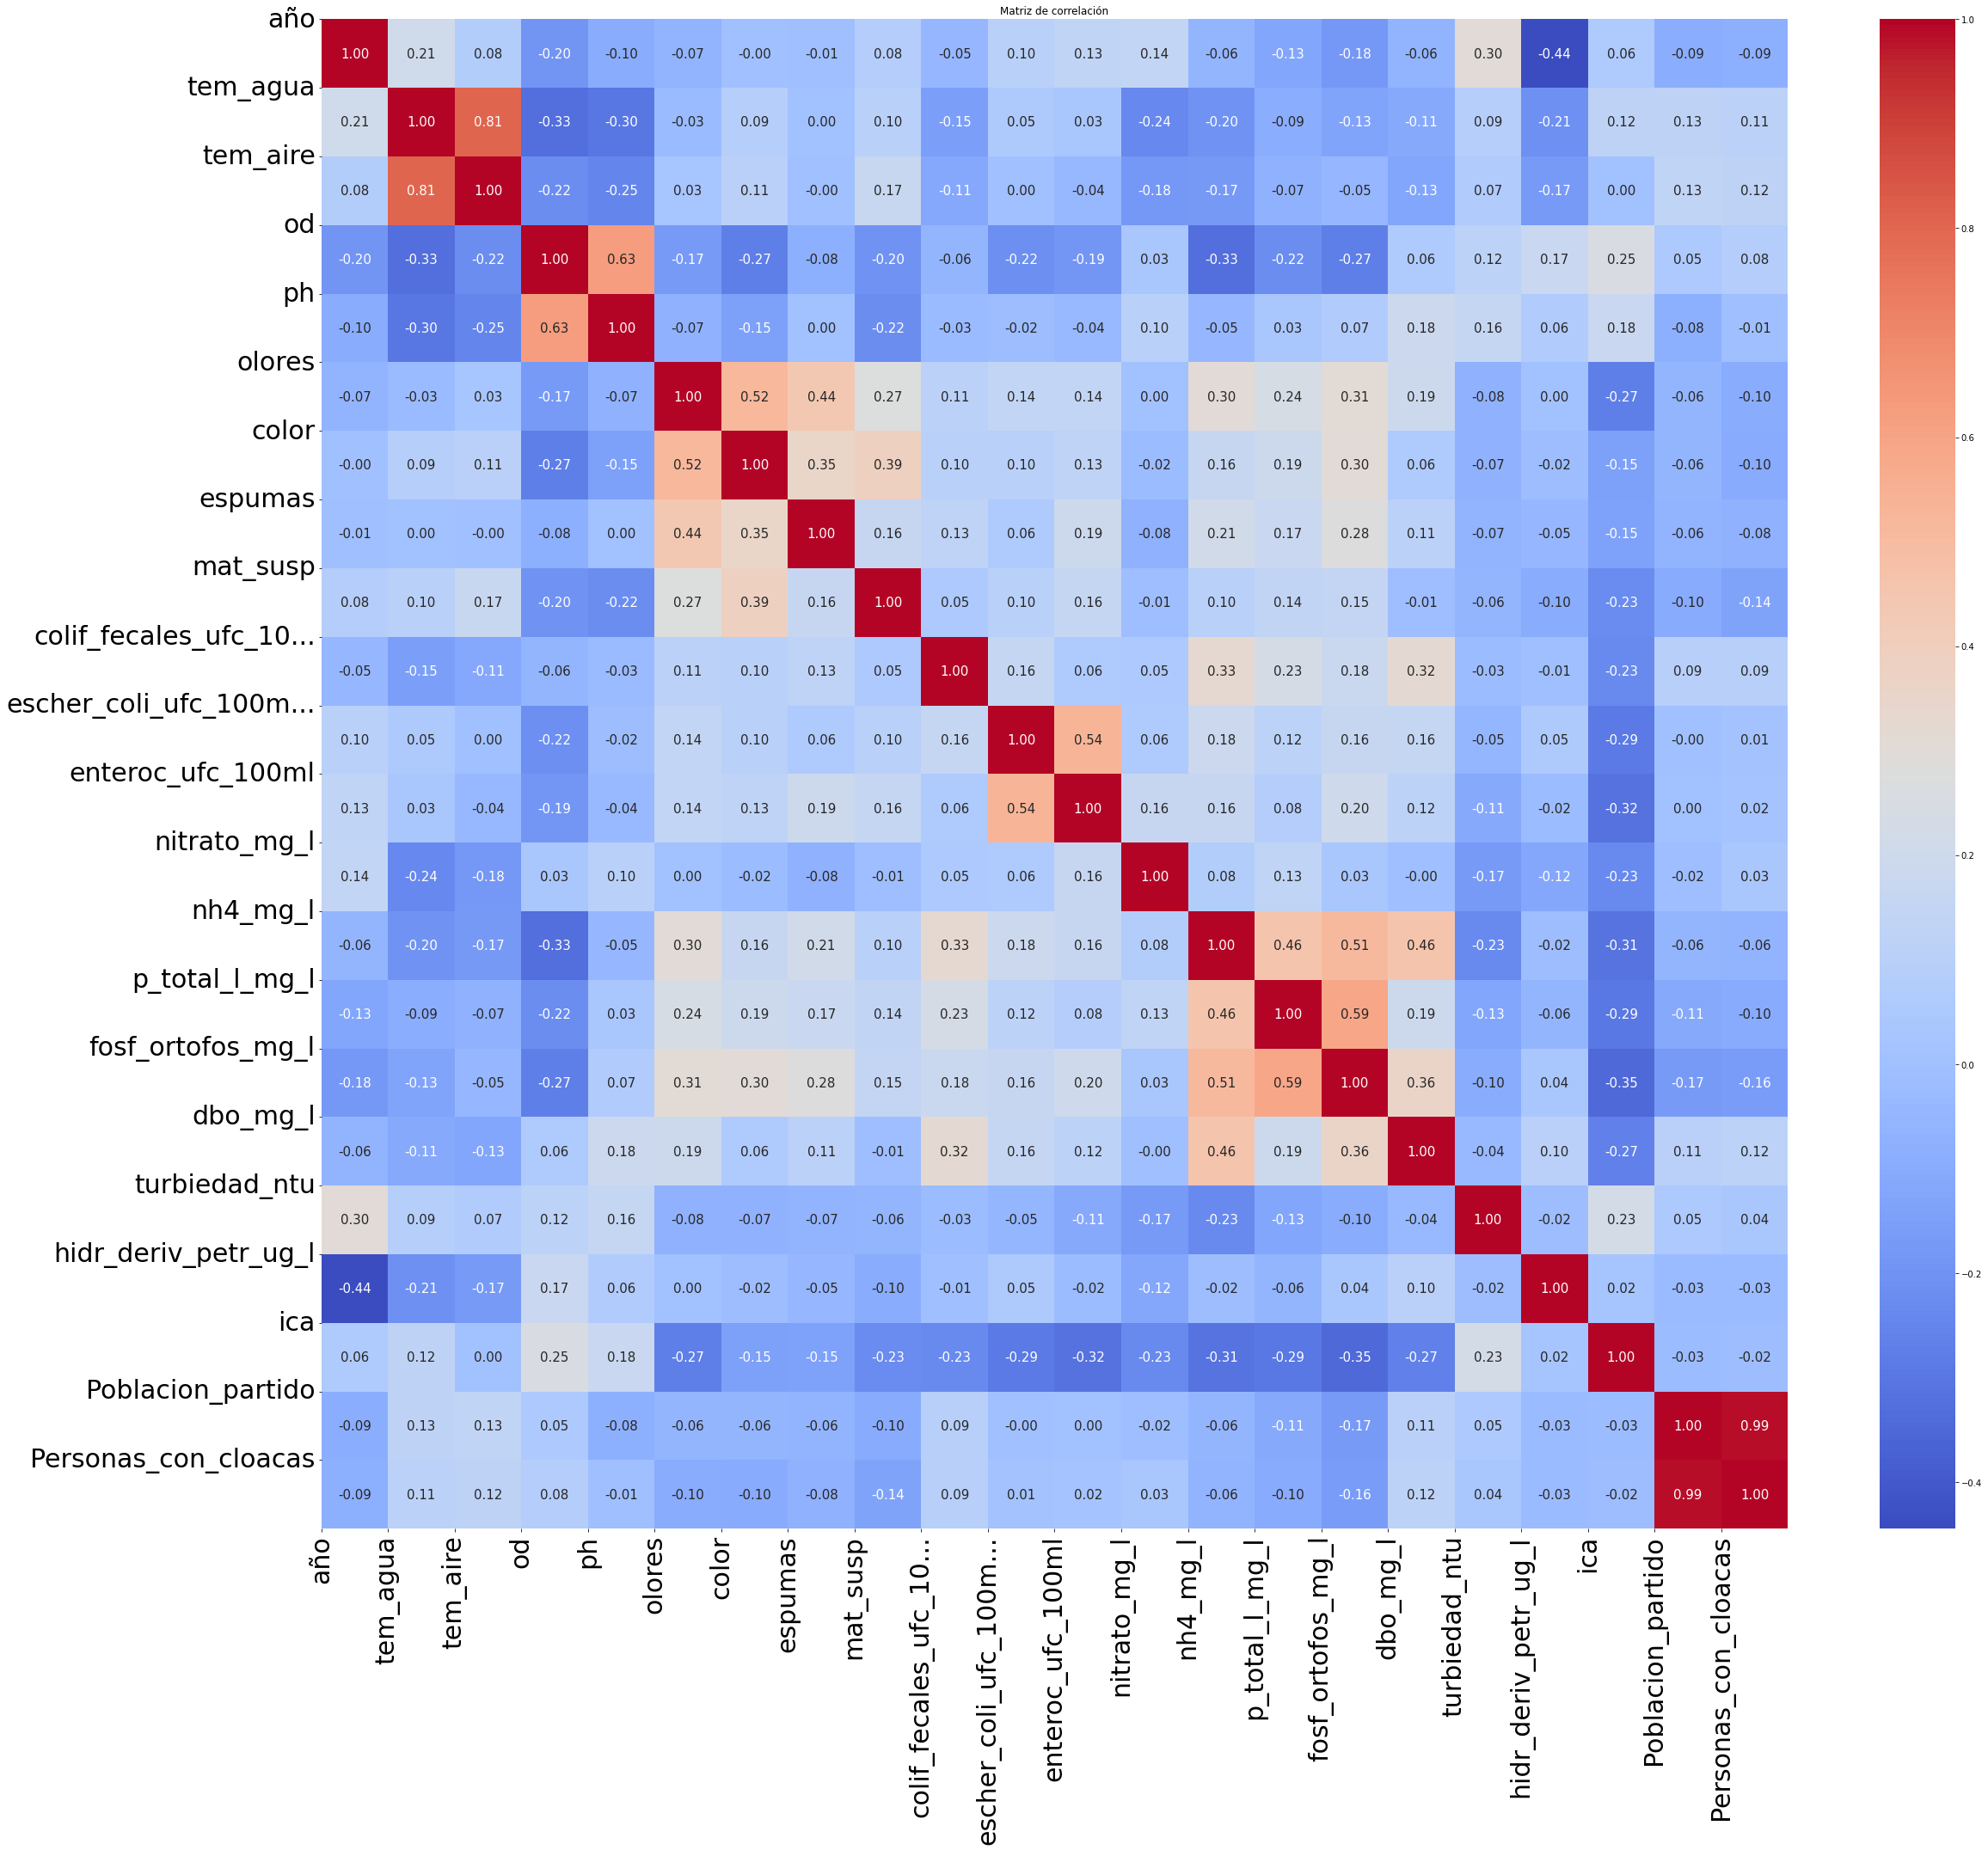

In [15]:
df_curado = pd.read_csv('./aguas_limpias_curacion_final.csv', low_memory=False)

# Correlacion entre variables
truncated_labels = [label[:20] + '...' if len(label) > 20 else label for label in df_curado.select_dtypes(include=['int64', 'float64']).columns.tolist()]

plt.figure(figsize=(35, 30))
sns.heatmap(df_curado.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 15})
plt.title("Matriz de correlación")
plt.yticks(ticks=range(len(truncated_labels)), labels=truncated_labels, rotation=0, fontsize=30)
plt.xticks(ticks=range(len(truncated_labels)), labels=truncated_labels, rotation=90, fontsize=30)
plt.tight_layout()
plt.show()

# 3. Curación de los Datos Categóricos

Aplicamos las mismas transformaciones realizadas en el Trabajo Práctico 1, con algunas modificaciones:

- Cambiar datos en formato serial de excel a formato dd/mm/yyyy
- Convertir todos los datos de tiempo a objetos pandas DataFrame, imputando los valores no válidos (cadenas del estilo 'no se midió) como NaT
- Pasamos todos los valores de campaña a minúscula. Eliminamos los que no correspondan a 'verano', 'otoño', 'invierno', 'primavera'
- En aquellas columnas que sólo admiten valores Asencia/Presencia -o similares-, imputamos como None aquellos valores que no correspondan a alguna de las categorías. Además, uniformamos los valores a 1 y 0 (a diferencia de lo hecho en el TP1, en el que seteamos a todos los valores válidos como'Ausente'/'Presente')
- Se imputan como None aquellos valores no válidos en calidad_de_agua
- Se imputan como NaN los valores no válidos en año -no hecho en TP 1-.
- Imputamos los datos faltantes relacionados con el Censo de 2022 y el Programa de Estudios del Conurbano usando la variable 'codigo':
    - Todas estas variables, salvo longitud y latitud, son imputadas usando sólo los dos primeros caracteres del código
    - Latitud y longitud no son imputadas, puesto que se observa que hay una correspondencia biunívoca entre latitud, longitud y código. No podemos asignar un único valor de latitud y longitud a cada municipio.

In [3]:
df1 = apply_date_correction_to_df(df) # Corrección columna 'fecha'
df2 = correct_campana(df1) # Corrección columna 'campaña'
df3 = correct_binary_categorical(df2) # Corrección de variables categóricas binarias
df4 = correct_calidad_del_agua(df3) # Corrección de variable calidad_de_agua
df5 = correct_year(df4) # Corrección variable año
df6 = imputation_per_muni(df5)

# Guardamos el nuevo df para no tener que volver a correr todo esto cada vez
df6.to_csv('./aguas_limpieza_solo_categoricas.csv', index=False)

Columna 'fecha' corregida
Columna 'camapaña' corregida
Columnas olores, color, espumas, mat_susp corregidas
Columna 'calidad_de_agua' corregida
Columna 'año' corregida
Imputación de variables de Censo y Programa de Conurbano -excepto longitud y latitud- usando código realizada


/home/edu/Facultad/DiploDatos/mentorias/TP2/TP2_version_3_con_correcciones_obligatorias/tp2_utils/df_categorical_transformations_utils.py:84: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df1['campaña'].astype(str).str.contains(patron, na=False)


In [4]:
# Visualicemos las correcciones anteriores
corrected_cols = ['fecha', 'campaña', 'olores', 'color', 'espumas', 'mat_susp', 'calidad_de_agua', 'año']
for col in corrected_cols:
    print('====================')
    print(col)
    print('====================')
    
    print(f"Valores en dataframe original:")
    print(df[col].unique())
    
    print(f"\nValores en dataframe corregido:")
    print(df6[col].unique())
    print("\n")

fecha
Valores en dataframe original:
['24/2/2021' '19/5/2021' '25/8/2021' '27/10/2021' nan '23/2/2022'
 '4/5/2022' '23/8/2022' '31/10/2022' 'no midieron este día' '31/10/0202'
 'no se midió' '23/8/2023' '22/2/2023' '10/5/2023' '14/11/2023' '8/4/2024'
 '45623' '45628' '12/4/2024' 'no se muestreó']

Valores en dataframe corregido:
<DatetimeArray>
['2021-02-24 00:00:00', '2021-05-19 00:00:00', '2021-08-25 00:00:00',
 '2021-10-27 00:00:00',                 'NaT', '2022-02-23 00:00:00',
 '2022-05-04 00:00:00', '2022-08-23 00:00:00', '2022-10-31 00:00:00',
 '2023-08-23 00:00:00', '2023-02-22 00:00:00', '2023-05-10 00:00:00',
 '2023-11-14 00:00:00', '2024-04-08 00:00:00', '2024-11-27 00:00:00',
 '2024-12-02 00:00:00', '2024-04-12 00:00:00']
Length: 17, dtype: datetime64[ns]


campaña
Valores en dataframe original:
['verano' 'otoño' 'invierno' 'primavera' nan 'Verano' 'Primavera'
 'no midieron este día' 'no se midió']

Valores en dataframe corregido:
['verano' 'otoño' 'invierno' 'primavera' na

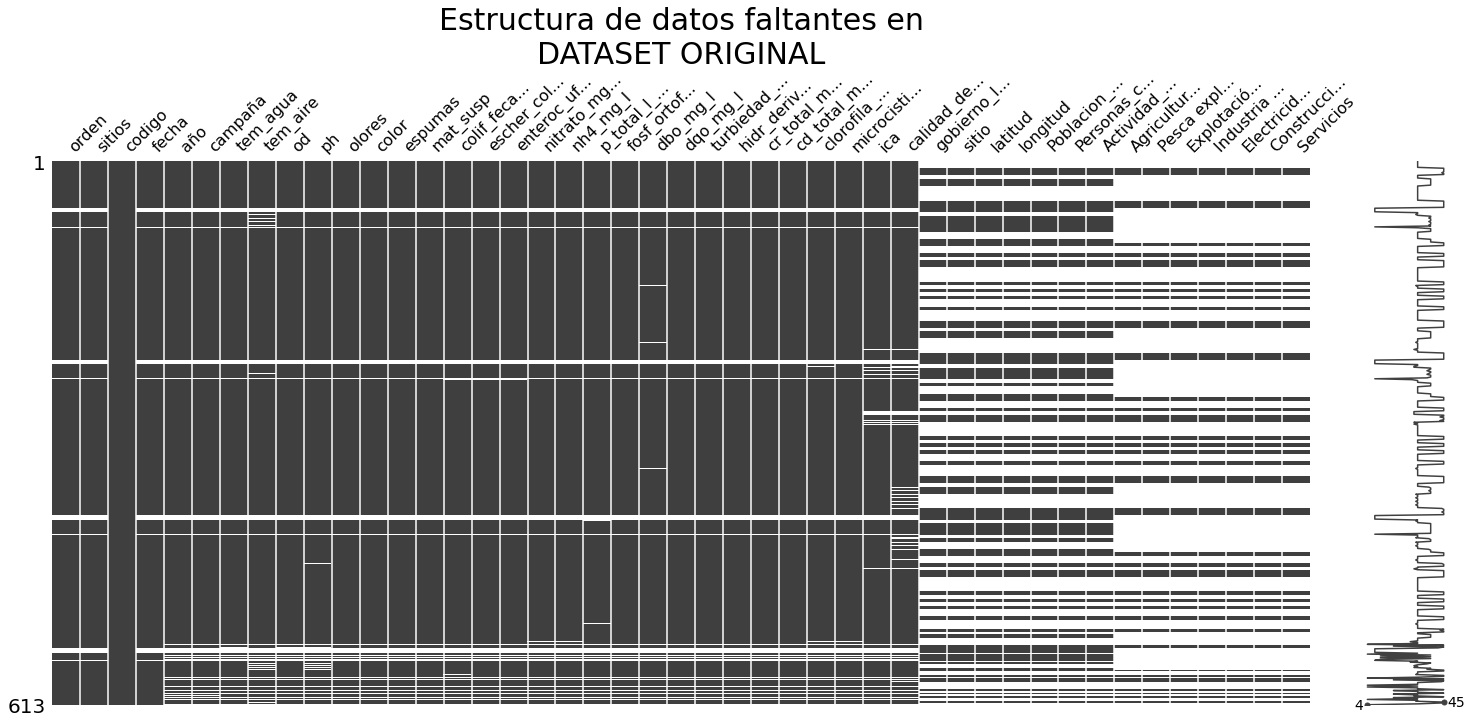

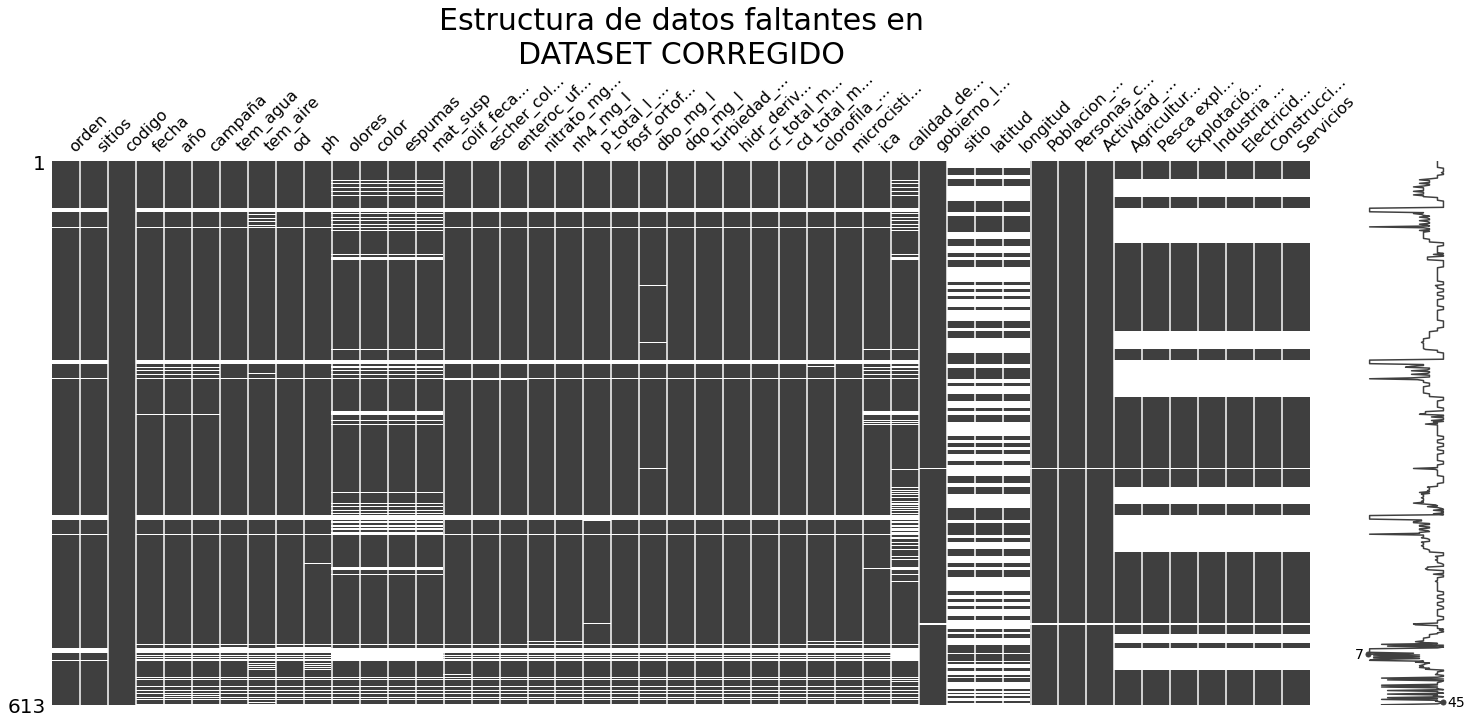

In [5]:
# Veamos cómo quedaron los valores faltantes con las imputaciones de las variables relacionadas al censo 2022 y al
    # Programa del Conurbano

# Dataset Original
missing_matrix(df, "Estructura de datos faltantes en\nDATASET ORIGINAL")

# Dataset Corregido
missing_matrix(df6, "Estructura de datos faltantes en\nDATASET CORREGIDO")

# 4. Curación de los Datos Numéricos

In [6]:
# Importamos dataset exportado en la sección anterior, a fin de no tener que volver a correr las celdas anteriores
df6 = pd.read_csv('./aguas_limpieza_solo_categoricas.csv', low_memory=False)

In [7]:
# Veamos con más detalle los valores en cada columna numérica con símbolos '<' y '>' y los comparemos con otros
    # valores de referencia de la misma columna
classifier = VariablesClassification()
numericas = classifier.numericas
for col in numericas:
    numerical_col_data(df6, col)

tem_agua 

No presenta valores con '<' 0 '>'
Mínimo: 6.0, Máximo: 29.4, Media: 19.44606490872211, Mediana: 19.6, Desviación Estándar: 5.008036867283525

---------------------------------------------------
tem_aire 

No presenta valores con '<' 0 '>'
Mínimo: 4.0, Máximo: 33.0, Media: 18.325258799171845, Mediana: 18.0, Desviación Estándar: 6.3286629533640335

---------------------------------------------------
od 

No presenta valores con '<' 0 '>'
Mínimo: 0.2, Máximo: 17.61, Media: 6.246427061310782, Mediana: 6.19, Desviación Estándar: 2.8622443123662444

---------------------------------------------------
ph 

No presenta valores con '<' 0 '>'
Mínimo: 5.0, Máximo: 10.5, Media: 7.509683972911964, Mediana: 7.41, Desviación Estándar: 0.7443493860400554

---------------------------------------------------
colif_fecales_ufc_100ml 

colif_fecales_ufc_100ml_comparison  colif_fecales_ufc_100ml_value
>                                   100000.0                         1
Name: count, dtype: int6

In [8]:
# Veamos cuántos valores encontramos en ciertos intérvalos de valores de algunas columnas (ver análisis en
    # siguiente celda)

col_interval(df6, 'fosf_ortofos_mg_l', minlim=0.1, maxlim=0.2)
col_interval(df6, 'fosf_ortofos_mg_l', maxlim=0.2)
col_interval(df6, 'dbo_mg_l', minlim=2, maxlim=5)
col_interval(df6, 'dbo_mg_l', maxlim=2)
col_interval(df6, 'dqo_mg_l', maxlim=50)
col_interval(df6, 'dqo_mg_l', maxlim=30)
col_interval(df6, 'dqo_mg_l', maxlim=2)
col_interval(df6, 'cr_total_mg_l', minlim=0.01)
col_interval(df6, 'cr_total_mg_l', maxlim=0.01)
col_interval(df6, 'clorofila_a_ug_l', maxlim=10)
col_interval(df6, 'clorofila_a_ug_l', maxlim=0.1)
col_interval(df6, 'clorofila_a_ug_l', maxlim=0.01)
col_interval(df6, 'microcistina_ug_l', maxlim=0.4)
col_interval(df6, 'microcistina_ug_l', maxlim=0.2)

Valores de fosf_ortofos_mg_l mayores a 0.1 y menores a 0.2 : 66 (10.77%)
Valores de fosf_ortofos_mg_l menores a 0.2 : 71 (11.58%)
Valores de dbo_mg_l mayores a 2 y menores a 5 : 163 (26.59%)
Valores de dbo_mg_l menores a 2 : 10 (1.63%)
Valores de dqo_mg_l menores a 50 : 137 (22.35%)
Valores de dqo_mg_l menores a 30 : 53 (8.65%)
Valores de dqo_mg_l menores a 2 : 0 (0.00%)
Valores de cr_total_mg_l mayores a 0.01 : 25 (4.08%)
Valores de cr_total_mg_l menores a 0.01 : 47 (7.67%)
Valores de clorofila_a_ug_l menores a 10 : 156 (25.45%)
Valores de clorofila_a_ug_l menores a 0.1 : 75 (12.23%)
Valores de clorofila_a_ug_l menores a 0.01 : 45 (7.34%)
Valores de microcistina_ug_l menores a 0.4 : 21 (3.43%)
Valores de microcistina_ug_l menores a 0.2 : 11 (1.79%)


En todas las variables numéricas, imputamos como NaN todos los valores no numéricos. Además, se imputan como NaN:

- En **colif_fecales_ufc_100ml**: El valor outlier, muy alejado de los demás valores (mayor a $2\times 10^6$ $UFC/100ml$) y el valor con símbolo '>', dado que es uno sólo y no altera significativamente la información que aporta la columna. 

- En **escher_coli_ufc_100ml**: Los tres outliers (valores por encima de $125.000$ $UFC/100ml$).

- En **enteroc_ufc_100ml**: Los dos valores outliers (mayores a $25.000$ $UFC/100ml$)

- En **nitrato_mg_l**: El valor outlier que se aleja significativamente del resto de los valores (mayor a $25$ $mg/l$) y los valores con símbolo '<', dado que son pocos (`~`7% de los datos, sumando un `~`23% junto con los valores nulos y demás no numéricos).

- En **nh4_mg_l**: El valor outlier, muy alejado de los demás valores (mayor a $25$ $mg/L$) y los valores con símbolo '<', que constituyen el `~`7% de los datos, sumando un `~`23% junto con los valores nulos y demás no numéricos.

- En **p_total_l_mg_l**: El valor outlier, muy alejado del resto de los valores (mayor a $5$ $mg/l$) y los 15 valores con símbolo '<', que representan `~`2% de los datos, sumando un `~`22% de los datos junto con los demás valores no numéricos y nulos.

- En **fosf_ortofos_mg_l**: Los dos valores outliers más alejados del conjunto de datos (mayores a $2$ $mg/l$) y los valores con símbolo '<', que constituyen aproximadamente el `~`8% de los datos totales, sumando junto con los demás no numéricos y los valores nulos un `~`35% de los datos. Si bien este porcentaje de datos faltantes (luego de estas imputaciones) es más considerable comparado con el de las columnas anteriores, sigue siendo lo suficientemente bajo como para considerar imputarlos si no alteran demasiado la distribución de los datos. Por otro lado, los números que se observan junto con el signo '<' son 0.1 y 0.2, y son en total 48. En la columna tenemos 71 valores numéricos (`~`12% del total) menores a $0.2$ $mg/l$, y 66 (`~`11%) entre $0.1$ $mg/l$ y $0.2$ $mg/l$, por lo que quitarle el signo '<' a los valores que lo tienen o imputarlos como cero alteran significativamente las distribución de la variable (como se vió en el TP1). Dado que tenemos muchos valores cercanos a $0.1$ $mg/l$ y $0.2$ $mg/l$, no encontramos prudente otra forma de imputación.

- En **dbo_mg_l**: El valor outlier (mayor a $25$ $mg/l$), muy alejado del resto de los valores, y los valores con símbolo '<'. Si bien estos últimos representan aproximadamente el 16% de los datos, llegando a sumar un `~`45% junto con los demás valores no numéricos y nulos (una proporción más considerable que en casos anteriores y que puede significar la necesidad de descartar la variable), tenemos 163 valores (`~`27%) entre $2$ $mg/l$ y $5$ $mg/l$ y 10 valores menores a $2$ $mg/l$ (1.6%), lo que dificulta imputar los valores '<2' y '<5' presentes en la columna sin alterar significativamente la distribución de los datos.

- En **dqo_mg_l**: Los valores outliers (mayores a $150$ $mg/l$) y los valores con símbolo '<', que constituyen un `~`37% del total de los datos, sumando un `~`63% junto con los demás valores no numéricos y nulos. Si bien estos últimos constituyen un porcentaje muy alto, y el imputar como NaN todos estos valores obliga a eliminar esta columna, tenemos dos motivos para realizar esta imputación en detrimento de cualquier otra: respecto a los valores '<30' y '<50', tenemos una apreciable cantidad de valores menores a $30$ $mg/l$ y $50$ $mg/l$; y respecto a '<2', el valor mínimo de la columna es $2.2$ $mg/l$, muy cercano a 2, lo que nos impide imputar de forma fiable este último valor.

- En **turbiedad_ntu**: El valor outlier (mayor a $300$ $ntu$), y los valores con símbolo '<', que son apenas `~`4% del total de datos, sumando un `~`20% junto con los demás valores no numéricos y nulos.

- En **hidr_deriv_petr_ug_l**: Los valores '<100.0', puesto que los pocos datos que tenemos tienen cierta densidad de datos entre $0$ y $100$ $\mu g/L$.

- En **cr_total_mg_l**: El valor outlier (mayor a $40$ $mg/l$) y los valores con símbolo '<'. Los valores de forma '<5.000', '<100.000' y '<10.000' se consideran sin sentido, por lo que se justifica la decisión de descartarlos (aunque podría especularse con que en realidad estén expresados en $\mu g/l$, lo que explicaría bien los valores, aunque no dejaría de ser una especulación). Los valores '<0.010' se descartan pues se tienen varios valores por debajo y por encima de $0.01$ $mg/l$. Por otro lado, los valores '<0.005', que constituyen el `~`51% de los datos, es muy difícil imputarlos por un valor puesto que los valores numéricos mínimos registrados son muy cercanos a $0.005$ $mg/l$ (aunque superiores), y no puede saberse si es más conveniente imputar esta gran cantidad de valores por valores cercanos, algún valor intermedio entre $0$ $mg/l$ y $0.005$ $mg/l$ o valores varios órdenes de magnitud menores a $0.005$ $mg/l$. Dado que el valor mínimo es $0.0052$ $mg/l$, podría especularse con imputar estos últimos valores con 0.005, entendiendo que así estos valore serían muy similares a los mínimos medidos, sin embargo la poca cantidad de valores numéricos (`~`19% del total de los datos) vuelve imprudente realizar este tipo de medidas.

- En **cd_total_mg_l**: Los valores con símbolo '<'. Todos los valores que tenemos nos llevan a descartar los valores de la forma '<1.000', puesto que este es dos órdenes de magnitud mayor que cualquier valor medido. Respecto al resto de los valores con símbolo '<', los números que acompañan al signo son del mismo orden que los valores numéricos medidos, lo que hace imposible imputar estos de forma adecuada. Además, los valores numéricos sólo representan el `~`2% de los totales, y siendo estos apenas 11 valores, es imposible hacer ninguna asunción de la distribución de esta variable.

- En **clorofila_a_ug_l**: Los valores outliers (mayores a $4000$ $\mu g/l$) y los valores con símbolo '<'. Cuando observamos los valores numéricos más pequeños de la columna (menores a $10$ $\mu g/l$, $0.1$ $\mu g/l$ y $0.01$ $\mu g/l$) observamos valores por encima y por debajo de todos estos, lo que hace muy difícil imputarlos. Esta observación es particularmente importante para el valor '<10.000', que es el más frecuente de los valores con símbolo '<' (149 valores, representando `~`24% del total), puesto que tenemos 156 valores numéricos (el `~`25% de los datos totales) menores a 10.

- En **microcistina_ug_l**: Se eliminan los tres outliers (mayores a $2$ $\mu g/L$) y los valores con símbolo '<'. Estos últimos representan un `~`75% de los valores totales. Esta última imputación obliga a eliminar esta columna, pero, de forma similar al caso de la columna anterior, no tenemos forma de imputar estos valores de forma confiable. El valor '>10.00' y '>5.00' son mayores que todos los valores numéricos medidos. por otro lado, la mayoría de los (pocos) valores medidos son del orden de $0.15$ $\mu g/L$ y $0.20$ $\mu g/L$.
 
Además:

- En **hidr_deriv_petr_ug_l**: No imputamos como NaN los valores outliers, dado que tenemos muy pocos datos numéricos como para saber si realmente son datos atípicos. Los valores '<0.1' se imputan como $0$ $\mu g/l$, dado que son menores al mínimo de $6.9$ $\mu g/L$ que se observa entre los valores numéricos.

Por último, se nota que los valores en 'Poblacion_partido' y 'Personas_con_cloacas' tienen puntos indicando la separación entre cifras de a 3, como es usual en español. Esto hace que, al pasar estos valores a numéricos, sean interpretados como números punto flotantes, salvo por la población de CABA que es interpretada como no numérica al tener dos puntos. Se eliminan los puntos de estos strings antes de pasarlos a valores numéricos.

In [9]:
# Imputamos como NaN los valores outliers
df7 = df6.copy()

cols_con_outliers = ['colif_fecales_ufc_100ml', 'escher_coli_ufc_100ml', 'enteroc_ufc_100ml', 'nitrato_mg_l',
                    'nh4_mg_l', 'p_total_l_mg_l', 'fosf_ortofos_mg_l', 'dbo_mg_l', 'dqo_mg_l', 'turbiedad_ntu',
                    'cr_total_mg_l', 'clorofila_a_ug_l', 'microcistina_ug_l']
outliers_lim = [2E6, 125000, 25000, 25, 25, 5, 2, 25, 150, 300, 40, 4000, 2]

for col, lim in zip(cols_con_outliers, outliers_lim):
    df7 = impute_outliers(df7, col, lim)

Imputación de valores outliers de columna colif_fecales_ufc_100ml -mayores a 2000000.0- completada)
Imputación de valores outliers de columna escher_coli_ufc_100ml -mayores a 125000- completada)
Imputación de valores outliers de columna enteroc_ufc_100ml -mayores a 25000- completada)
Imputación de valores outliers de columna nitrato_mg_l -mayores a 25- completada)
Imputación de valores outliers de columna nh4_mg_l -mayores a 25- completada)
Imputación de valores outliers de columna p_total_l_mg_l -mayores a 5- completada)
Imputación de valores outliers de columna fosf_ortofos_mg_l -mayores a 2- completada)
Imputación de valores outliers de columna dbo_mg_l -mayores a 25- completada)
Imputación de valores outliers de columna dqo_mg_l -mayores a 150- completada)
Imputación de valores outliers de columna turbiedad_ntu -mayores a 300- completada)
Imputación de valores outliers de columna cr_total_mg_l -mayores a 40- completada)
Imputación de valores outliers de columna clorofila_a_ug_l -ma

In [10]:
# Imputamos como 0 los valores '<0.10' en hidr_deriv_petr_ug_l
df8 = df7.copy()
df8 = imput_hidr_01(df8)

Imputación de valores '<0.10', ' <0.10', ' 0.10' y ' 0.20' en columna hidr_deriv_petr_ug_l completada


In [11]:
# Eliminamos los puntos de los valores numéricos en Poblacion_partido y Personas_con_cloacas
df9 = df8.copy()
df9 = remove_dots_in_populations(df9)

Eliminación de puntos en los valores de 'Poblacion_partido' y 'Personas_con_cloacas' completada


In [15]:
# imputamos como NaN los valores no numéricos de las variables numéricas, y transformamos las columnas
    # correspondientes a numéricas
df10 = df9.copy()
df10 = set_to_numerical(df10)

# Guardamos el nuevo df para no tener que volver a correr todo esto cada vez
# df6.to_csv('./aguas_limpieza_final.csv', index=False)
df10.to_csv('./aguas_limpieza_numericas_y_categoricas.csv', index=False)

Imputación de valores no numéricos de variables numéricas completada.


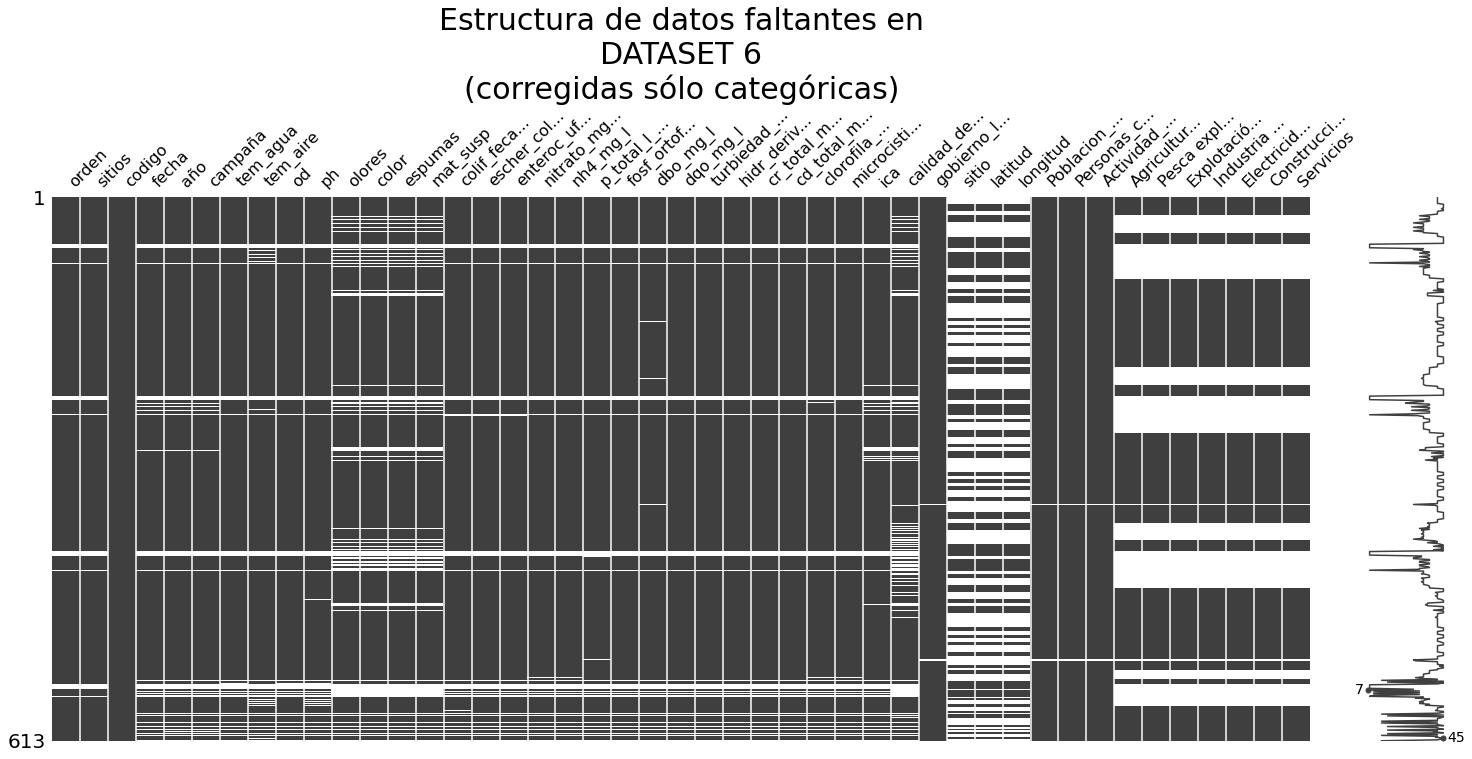

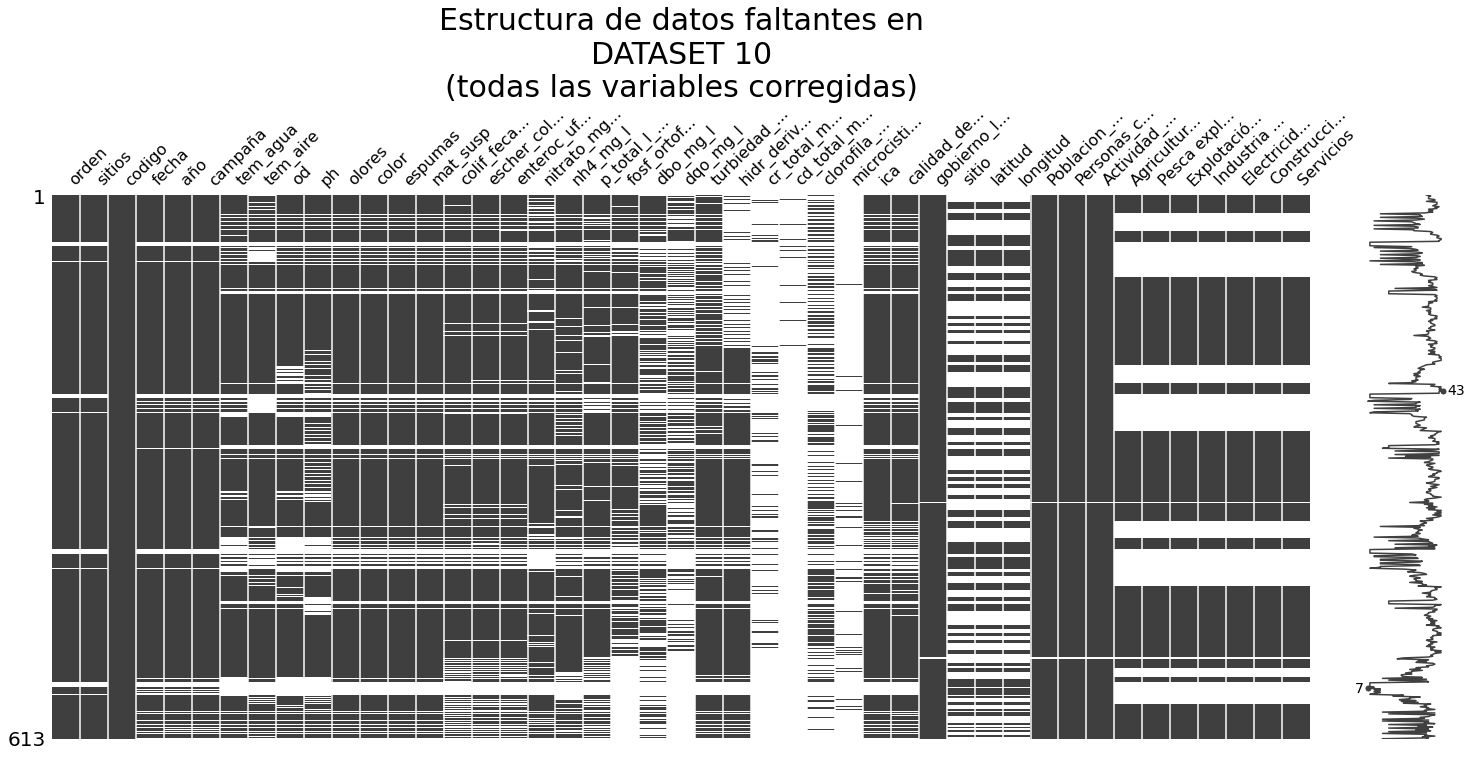

In [13]:
# Veamos cómo quedaron los valores faltantes con las imputaciones en las variables numéricas

# Dataset ANTES de las imputaciones numéricas
missing_matrix(df6, "Estructura de datos faltantes en\nDATASET 6\n(corregidas sólo categóricas)")

# Dataset DESPUÉS de las imputaciones numéricas
missing_matrix(df10, "Estructura de datos faltantes en\nDATASET 10\n(todas las variables corregidas)")

# 5. Curación: Eliminación de Columnas y Filas

In [16]:
# Cargamos el dataset obtenido del paso anterior, para evitar tener que volver a correr las celdas anteriores:
df10 = pd.read_csv('./aguas_limpieza_numericas_y_categoricas.csv', low_memory=False)

En esta sección procederemos a eliminar registros y columnas que consideremos innecesarios para nuestro porpósito o que tengan una gran cantidad de datos faltantes. También eliminaremos registros duplicados. A continuación se brindan más detalles de las decisiones:

- Como se observó en el TP1, los registros duplicados* tienen todos los valores en las variables fisico-químicas y temporales, así como tambien en ICA y calidad_del_agua, como faltantes. Se decide eliminar todos los registros con todos los valores en las variables numéricas continuas y categóricas binarias como faltantes (ignorando latitud y longitud que, como se explica después, se consideran irrelevantes).
- Se eliminan aquellas columnas cuyo porcentaje de datos faltantes sea superior al 40%.
- Se eliminan registros con valores faltantes en 'ica'.
- Se eliminan las columnas consideradas irrelevantes para nuestro trabajo:
    - 'orden','sitios', 'sitio': La identificación de los puntos de recolección de datos se efectuará solamente a través de la codificación. De este modo, puede mapearse el contenido de las variables adicionales en la identificación del punto de medición para cada registro. Dichas variables son categóricas, aunque no aportan en el modelo de predicción de la variable objetivo. Tal afirmación de basa en la falta de información acerca de distribuciones internas por región. Geográficamente, pese a pertenecer a la misma región, el comportamiento de las mediciones en dos puntos diferentes no necesariamente es similar. Independientemente, de desearse utilizar alguna de estas columnas como identificador de punto de medición, no sería la forma más práctica y se procedería a codificar.
    - 'fecha': Tras un análisis exploratorio y una curación de los datos se han identificado las fechas, arrojándose un patrón de escasos valores. Cada fecha corresponde a una única por temporada, con lo cual no se puede identificar una variación en las mediciones a lo largo de cada una de ellas. Independientemente de tratarse de fechas de medición o de carga de datos, no se provee de suficiente información a lo largo de cada temporada y esta columna cumple la misma función que “campaña”. Por lo tanto, se opta por emplear esta última.
    - 'calidad_de_agua': Se conoce a priori la clasificación de grados de calidad de agua en base al ICA. Por lo tanto, esta columna es innecesaria y el contenido puede simplemente codificarse en base a dicha escala tras la obtención del ICA (variable objetivo) correspondiente.
    - 'latitud', 'longitud': Ambas variables son numéricas, tal como se ha hecho mención previamente, aunque para el fin de este trabajo carecen de relevancia. Los datos recolectados corresponden a los 25 puntos de medición distribuidos en la costa del Río de La Plata de forma excluyente. Bajo tal premisa, las ubicaciones geográficas de otros puntos no serán de consideración para la predicción del Índice de Calidad del Agua, pues se carece de información necesaria para describir la influencia de factores influyentes, sin cuya incorporación en el modelo los resultados podrían arrojar desvíos considerables. En otras palabras, las predicciones a efectuar se corresponderán única y exclusivamente a los puntos de recolección de datos provistos, sin la ampliación a otras regiones asumiendo un comportamiento desconocido. Además de la irrelevancia de otras ubicaciones fuera de las definidas, la consideración de esta columna requeriría innecesariamente una verificación de los registros y potencialmente una corrección o imputación de aquellos donde corresponda, lo cual encarece el tiempo de procesamiento.
    - 'Actividad_principal', 'gobierno_local': Dichas variables caracterizan a las regiones asignando valores que pueden codificarse y que no aportan al análisis. Mientras que las dos primeras no se alterarían con el tiempo (son inherentes a cada punto de medición), la actividad principal puede sufrir modificaciones en base a los datos obtenidos originalmente. Sin embargo, la actividad principal aporta información de difícil aprovechamiento, pues no cuantifica la diferencia respecto a otros tipos de actividades desarrolladas ni la influencia en el ICA. Por ejemplo, de no alterarse el desarrollo de las actividades económicas en una determinada localización pero agregándose una nueva sustancialmente cuyo impacto en el ICA sea nulo, la actividad principal variaría, lo cual influiría en las predicciones pese a lo deseado. Por este motivo, se desestima también esta columna en las predicciones.
    - Rankings 0-7 (Servicios; Construcción;…): de modo similar al caso de la actividad principal, resulta dificultoso el aprovechamiento de la escasa información que estas variables numéricas ordinales proveen. Tal dificultad reside principalmente en la carencia de cuantificaciones. Ordenar los distritos por relevancia de una determinada actividad no garantiza la relevancia de la misma en él. Además, la escala lineal provista en la clasificación en cuestión (o una transformación de la misma) no se corresponde con las diferencias en representatividad. Por ejemplo, en dos distritos donde la actividad “Explotación de minas y canteras” es insignificante por igual, se da una asignación con posiciones diferentes pese a la igualdad. Diferencia tal se manifiesta de igual modo que respecto a otro distrito donde sí tal actividad es representativa. Por lo tanto, se decide no considerar esta variable en el modelo. De igual modo que en lo anteriormente mencionado, podrían también darse diferencias en las actividades desarrolladas a lo largo del tiempo, sumándole complejidad al modelo y la necesidad de actualizaciones. Como consideración adicional (pero no necesariamente válida luego de realizar imputaciones) para la supresión de dichas variables  puede mencionarse el gran número de faltantes en estas columnas el data set original.

*<u>Nota</u>: A diferencia del TP1, con las nuevas imputaciones se pasa a tener de 18 a 23 filas duplicadas.

In [17]:
# Eliminación de registros que tengan todos sus valores en las columnas numéricas continuas y categóricas binarias
    # como faltantes (incluyen todas las columnas duplicadas)
df11 = remove_null_rows(df10)

Se eliminaron 89 registros nulos.


In [18]:
# Eliminamos columnas consideradas irrelevantes
irrelevant_cols = [
    'orden',
    'sitios',
    'fecha',
    'calidad_de_agua',
    'gobierno_local',
    'sitio',
    'latitud',
    'longitud',
    'Actividad_principal',
    'Agricultura, ganadería, caza y silvicultura',
    'Pesca explotación de criaderos de peces y granjas piscícolas y servicios conexos',
    'Explotación de minas y canteras',
    'Industria Manufacturera',
    'Electricidad, gas y agua',
    'Construcción',
    'Servicios'
]
df12 = df11.drop(irrelevant_cols, axis=1)

In [20]:
# Veamos cuántos qué porcentaje de datos faltantes tenemos por columna y eliminemos las que superen un 40%
df13 = remove_columns_with_too_many_sull(df12, 40)

Columna			Porcentaje de Nulos
codigo                      0.000000
año                         0.190840
campaña                     0.190840
tem_agua                    5.916031
tem_aire                    7.824427
od                          9.732824
ph                         15.458015
olores                      0.000000
color                       0.000000
espumas                     0.000000
mat_susp                    0.000000
colif_fecales_ufc_100ml     8.015267
escher_coli_ufc_100ml       6.679389
enteroc_ufc_100ml           6.679389
nitrato_mg_l               10.496183
nh4_mg_l                    9.160305
p_total_l_mg_l              9.351145
fosf_ortofos_mg_l          24.045802
dbo_mg_l                   36.259542
dqo_mg_l                   57.251908
turbiedad_ntu               6.106870
hidr_deriv_petr_ug_l       24.427481
cr_total_mg_l              86.259542
cd_total_mg_l              97.900763
clorofila_a_ug_l           47.519084
microcistina_ug_l          92.748092
ica     

In [21]:
# Eliminamos filas con valor nulo en 'ica'
df14 = df13.dropna(subset=['ica'])
print(f"Se eliminan {len(df13)-len(df14)} filas con valor nulo en 'ica'. Nos quedan en total {len(df14)} de las 613 filas originales.")

Se eliminan 15 filas con valor nulo en 'ica'. Nos quedan en total 509 de las 613 filas originales.


In [22]:
df14.to_csv('./aguas_limpias_curacion_final.csv', index=False)

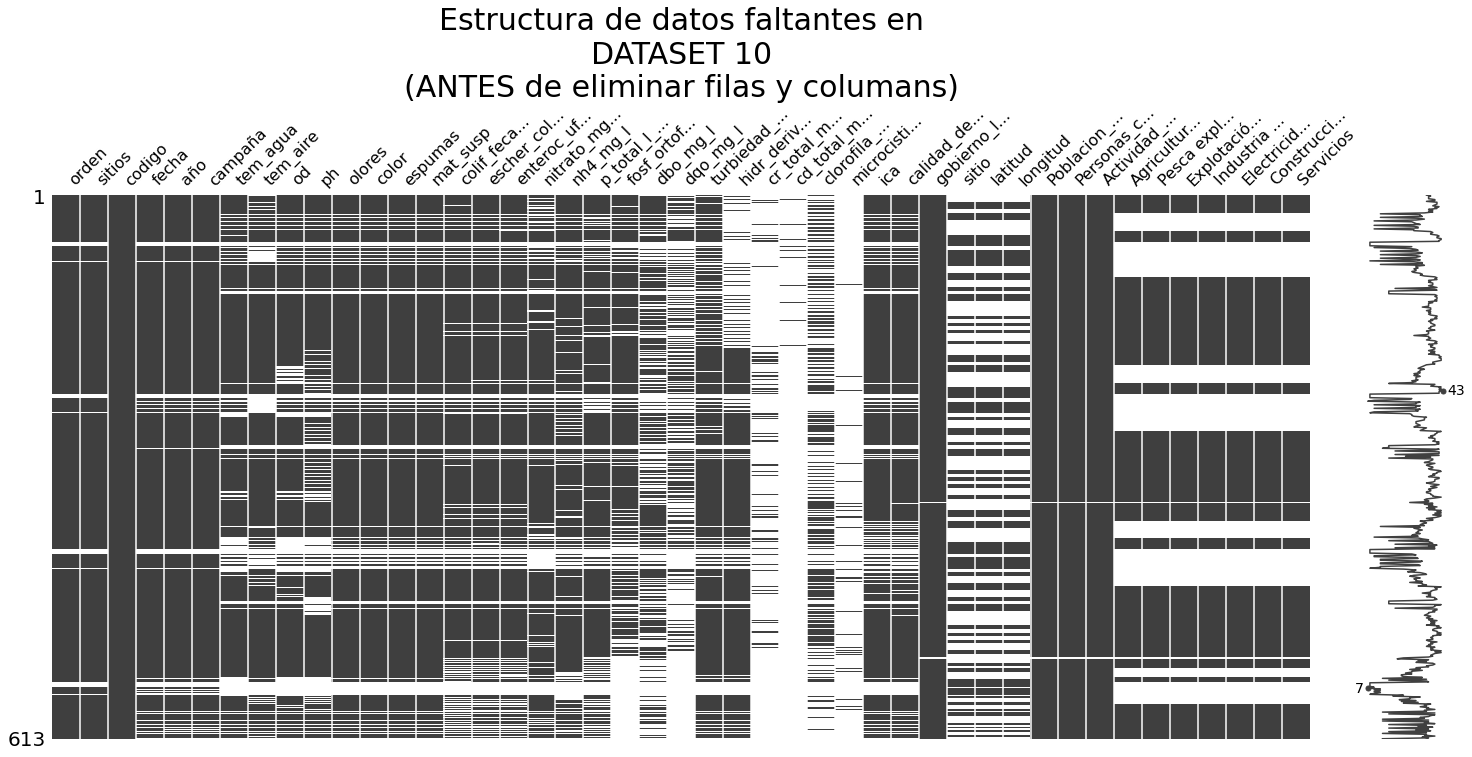

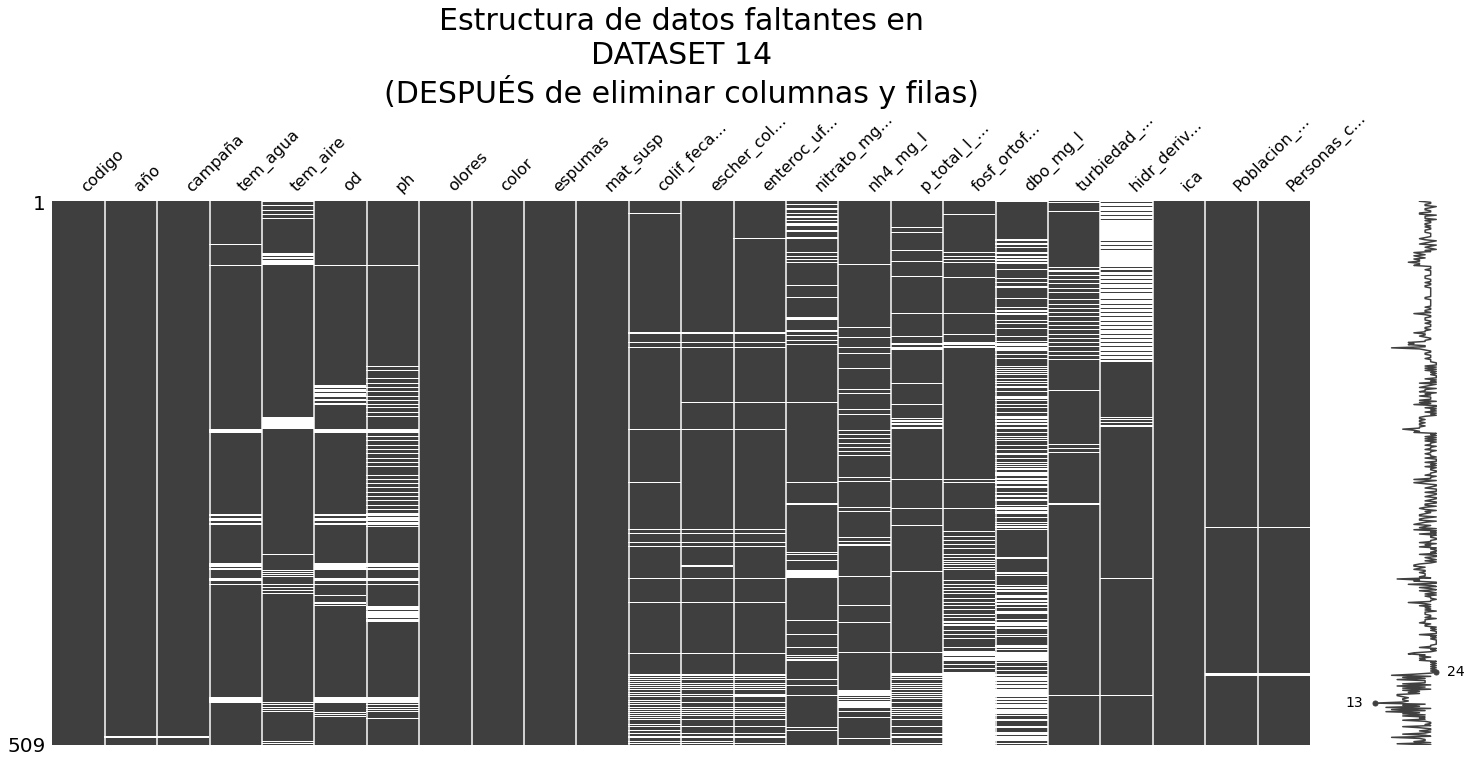

In [23]:
# Veamos la nueva estructura de valores faltantes y la comparemos con la anterior

# Dataset SIN eliminar columnas ni filas
missing_matrix(df10, "Estructura de datos faltantes en\nDATASET 10\n(ANTES de eliminar filas y columans)")

# Dataset DESPUÉS de eliminar columnas ni filas
missing_matrix(df14, "Estructura de datos faltantes en\nDATASET 14\n(DESPUÉS de eliminar columnas y filas)")

# 6. Variables correlacionadas: Primera ramificación

Evaluamos la correlación entre variables. Presentamos dos propuestas de datasets a entrenar: Una que conserve todas las variables conservadas de la limpieza anterior (**A**) y otra en la que se eliminen las variables numéricas que estén altamente correlacionadas (|r| > 0.85), dejando solo una de cada grupo correlacionado.

In [24]:
df_A = pd.read_csv('./aguas_limpias_curacion_final.csv', low_memory=False)

In [25]:
df_B = remove_correlated_cols(df_A, 0.85)

Columnas eliminadas por alta correlación: Personas_con_cloacas


In [27]:
# Exportamos los datasets
df_A.to_csv('./A_sets/aguas_limpias_A_inicial.csv', index=False)
df_B.to_csv('./B_sets/aguas_limpias_B_inicial.csv', index=False)

# 7. División del Dataset

- Se usa ICA como variable objetivo para regresión.
- Se realiza la división en train (80%) y test (20%) para ambos datasets.

In [30]:
# 1. Leer el datasets A y B desde CSV
df_A = pd.read_csv("./A_sets/aguas_limpias_A_inicial.csv")
df_B = pd.read_csv("./B_sets/aguas_limpias_B_inicial.csv")

In [31]:
target_col = 'ica'
test_fraction = 0.2
random_seed = 42

X_A_train, X_A_test, y_A_train, y_A_test = split_in_tt(df_A, target_col, test_fraction, random_seed=random_seed)
X_B_train, X_B_test, y_B_train, y_B_test = split_in_tt(df_B, target_col, test_fraction, random_seed=random_seed)

Train: 407, muestras (79.96%)
Test: 102, muestras (20.04%)
Train: 407, muestras (79.96%)
Test: 102, muestras (20.04%)


In [32]:
# Exportamos los datasets
X_A_train.to_csv('./A_sets/x_train_inicial.csv', index=False)
y_A_train.to_csv('./A_sets/y_train_inicial.csv', index=False)
X_A_test.to_csv('./A_sets/x_test_inicial.csv', index=False)
y_A_test.to_csv('./A_sets/y_test_inicial.csv', index=False)
X_B_train.to_csv('./B_sets/x_train_inicial.csv', index=False)
y_B_train.to_csv('./B_sets/y_train_inicial.csv', index=False)
X_B_test.to_csv('./B_sets/x_test_inicial.csv', index=False)
y_B_test.to_csv('./B_sets/y_test_inicial.csv', index=False)

# 8. Imputaciones de Variables Numéricas

Decidimos cuáles son las mejores opciones para la imputación de variables numéricas. Para ello, exploramos varias opciones para la imputación sobre el conjunto de entrenamiento: KNN con 3 y 7 vecinos, e imputación iterativa con regresión de cresta bayesiana.

In [33]:
X_A_train = pd.read_csv('./A_sets/x_train_inicial.csv')
y_A_train = pd.read_csv('./A_sets/y_train_inicial.csv')
X_A_test = pd.read_csv('./A_sets/x_test_inicial.csv')
y_A_test = pd.read_csv('./A_sets/y_test_inicial.csv')
X_B_train = pd.read_csv('./B_sets/x_train_inicial.csv')
y_B_train = pd.read_csv('./B_sets/y_train_inicial.csv')
X_B_test = pd.read_csv('./B_sets/x_test_inicial.csv')
y_B_test = pd.read_csv('./B_sets/y_test_inicial.csv')

In [34]:
# Identificamos columnas numéricas y categóricas.
num = X_A_train.select_dtypes(include=['int64', 'float64']).columns
numerical_cols_A = [col for col in num if not col in ['año', 'olores', 'color', 'espumas', 'mat_susp']]
numerical_cols_B = [col for col in numerical_cols_A if not 'Personas_con_cloacas' in col]

cat = X_A_train.select_dtypes(include=['object', 'category']).columns
categorical_cols = list(cat)+['año', 'olores', 'color', 'espumas', 'mat_susp']

Para dataset A


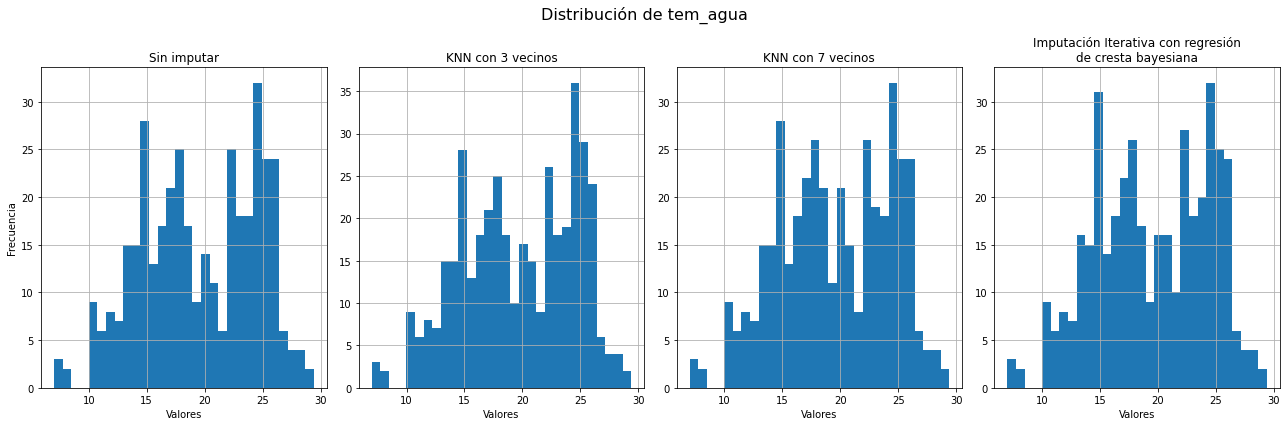

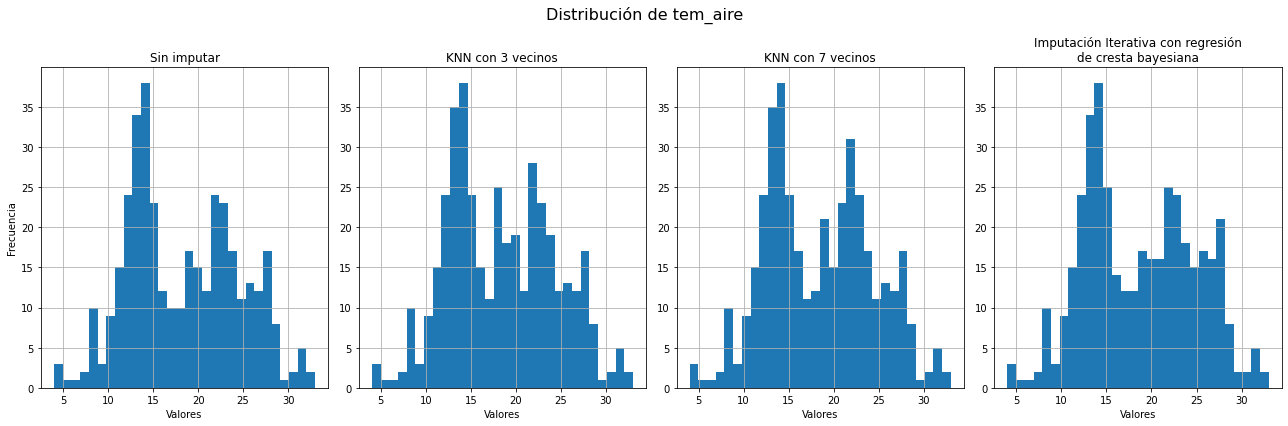

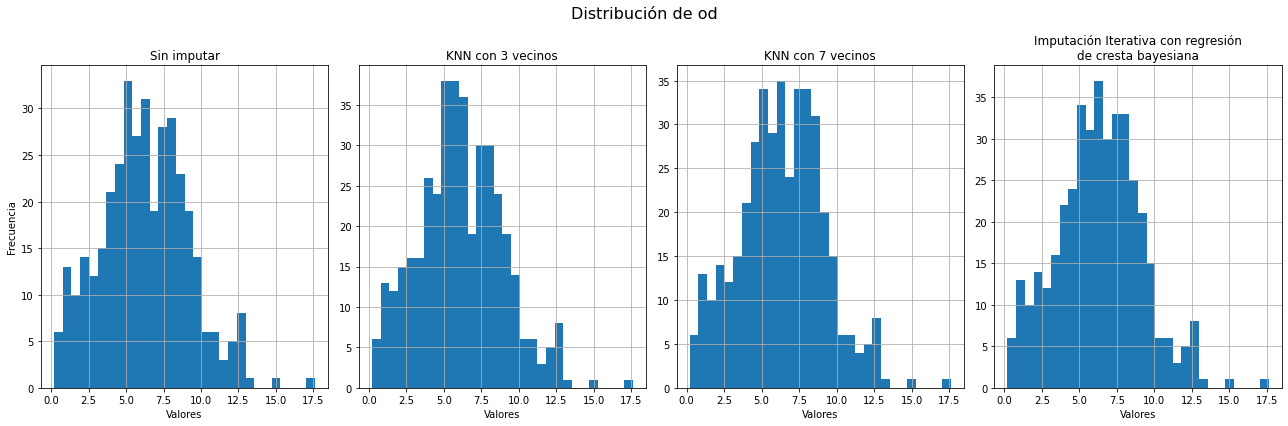

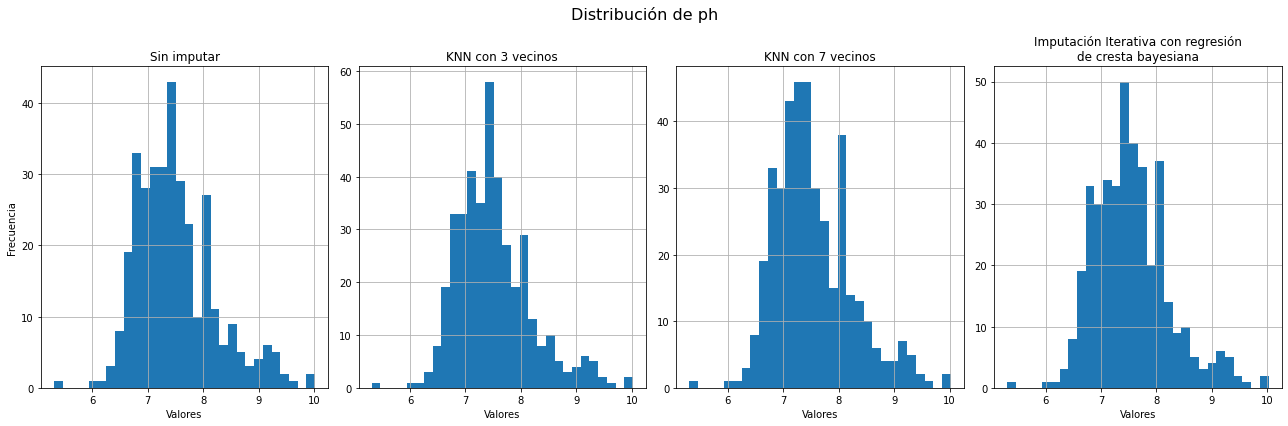

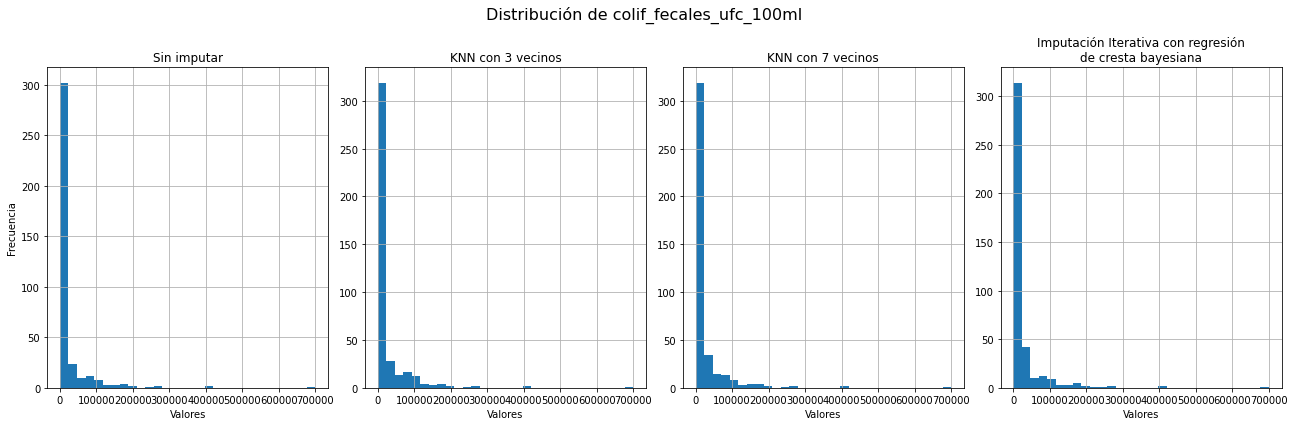

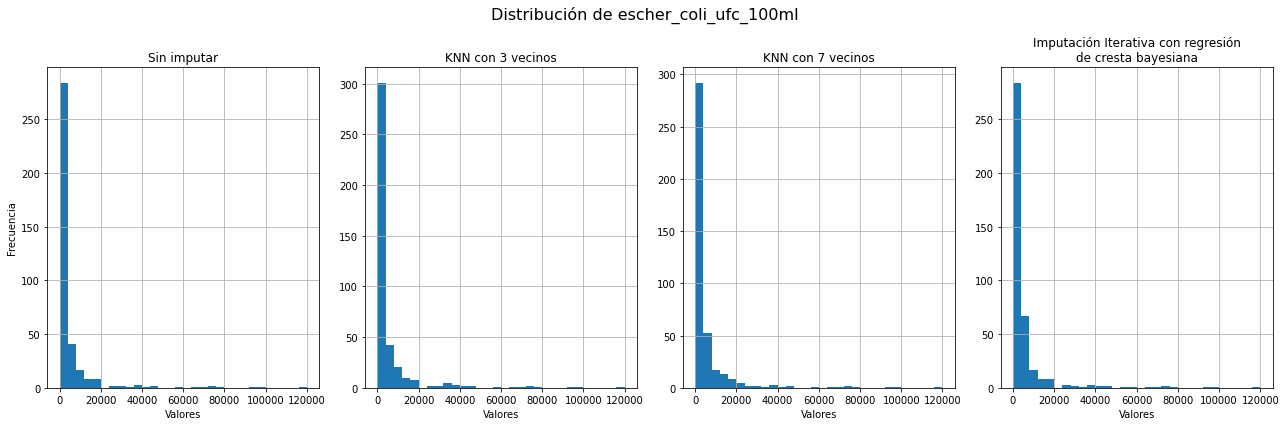

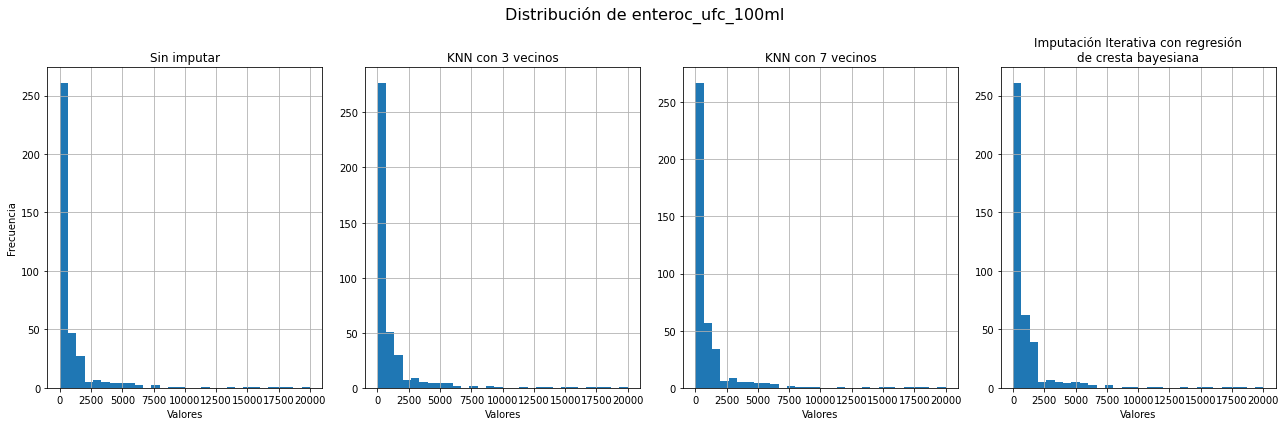

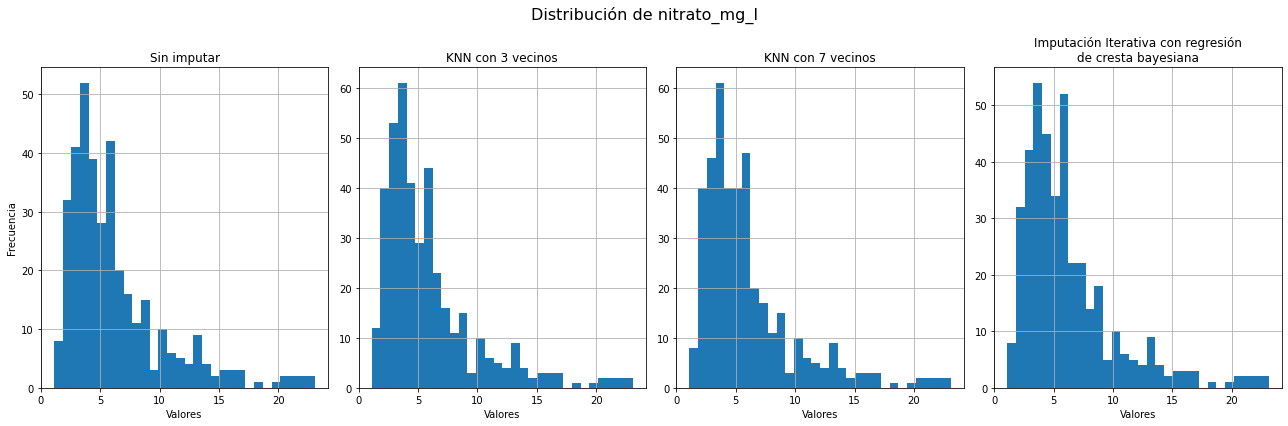

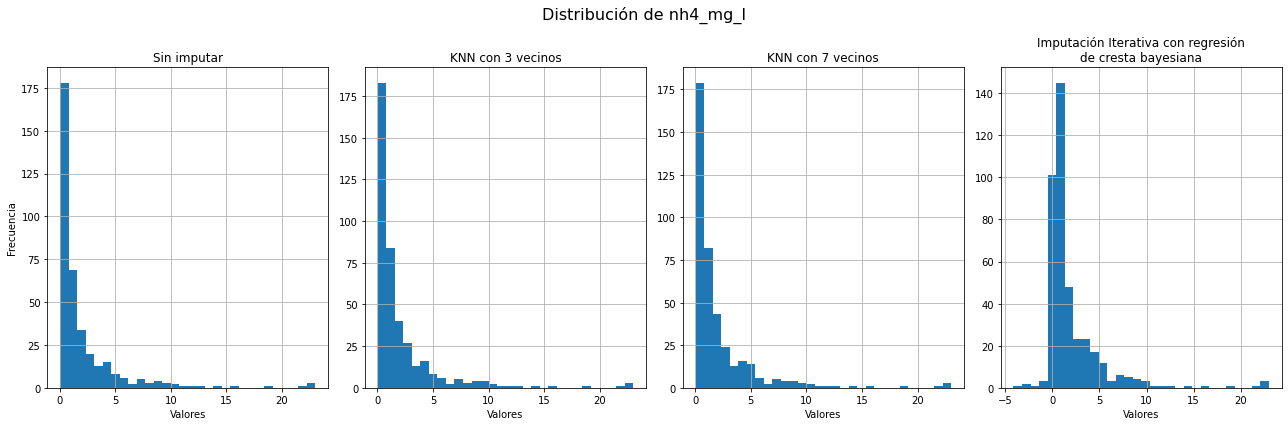

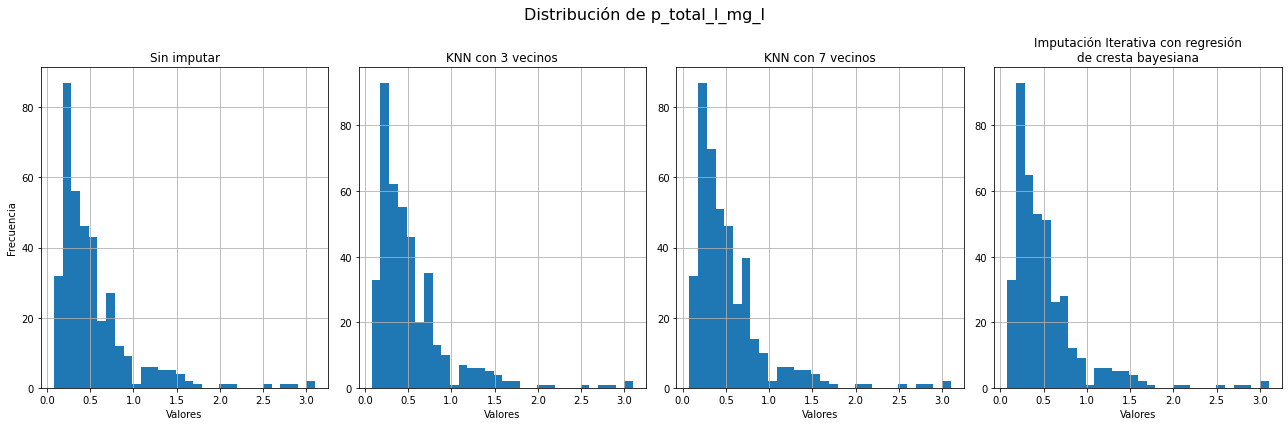

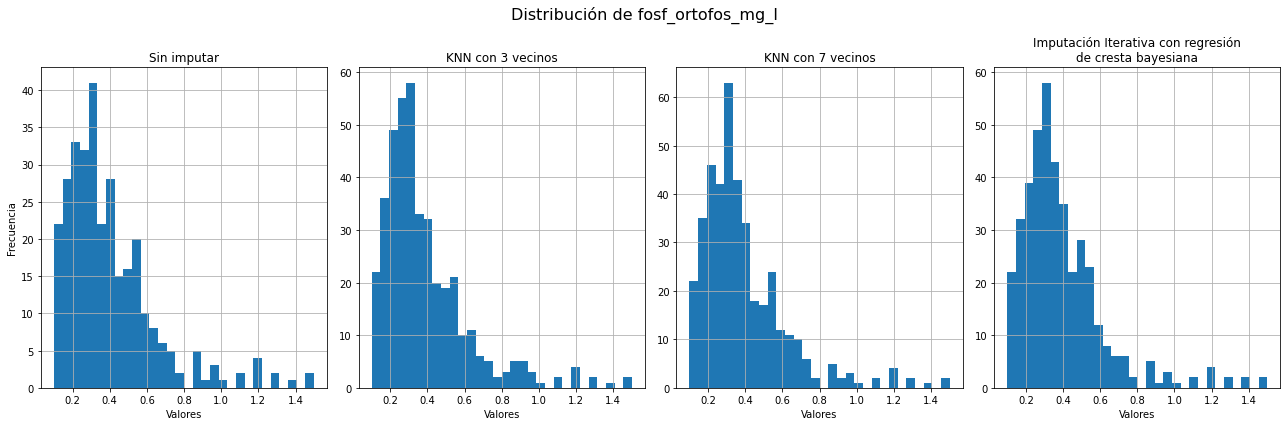

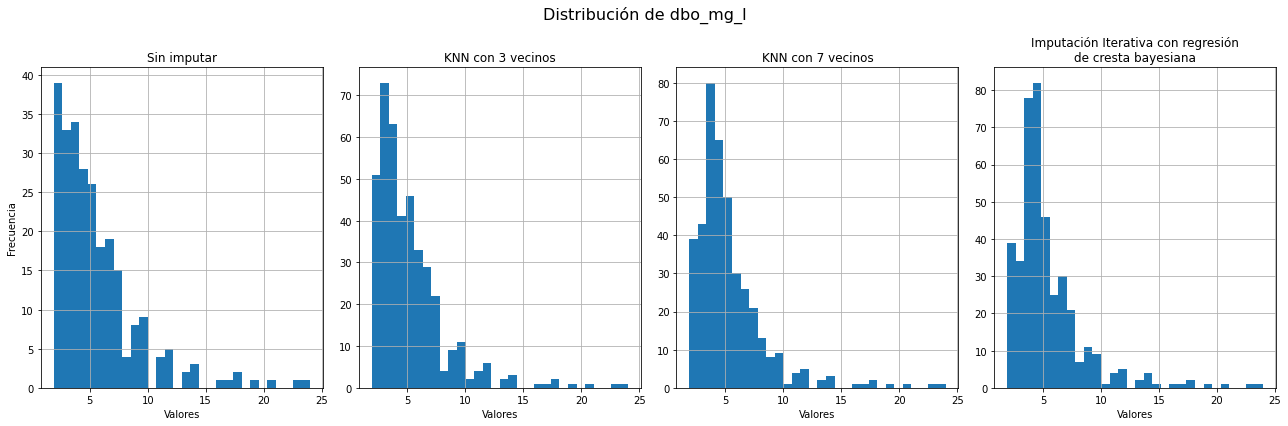

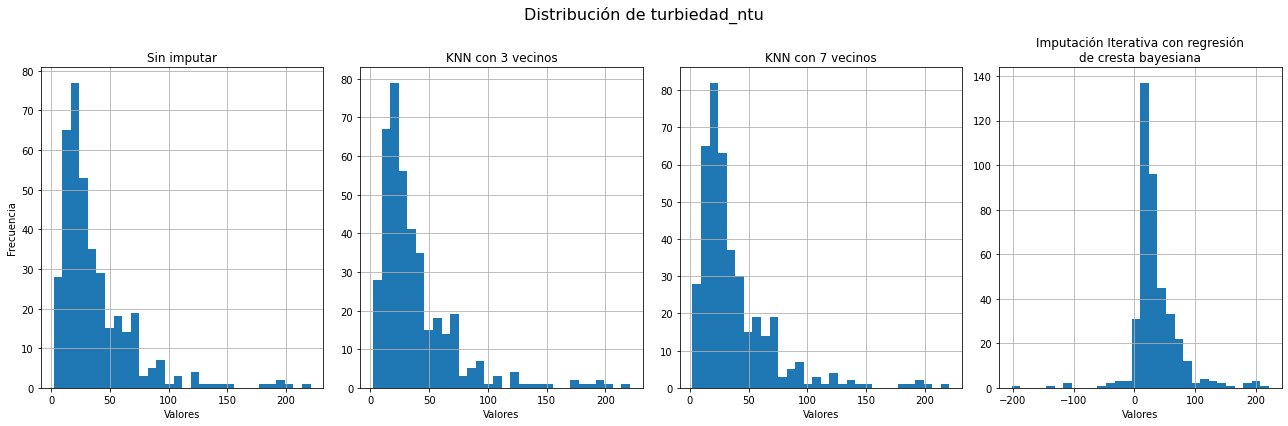

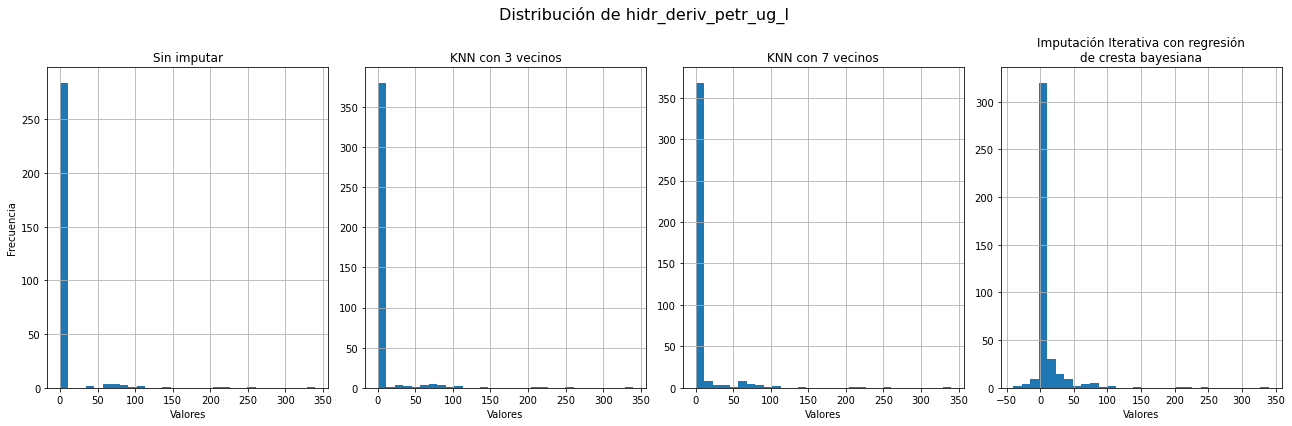

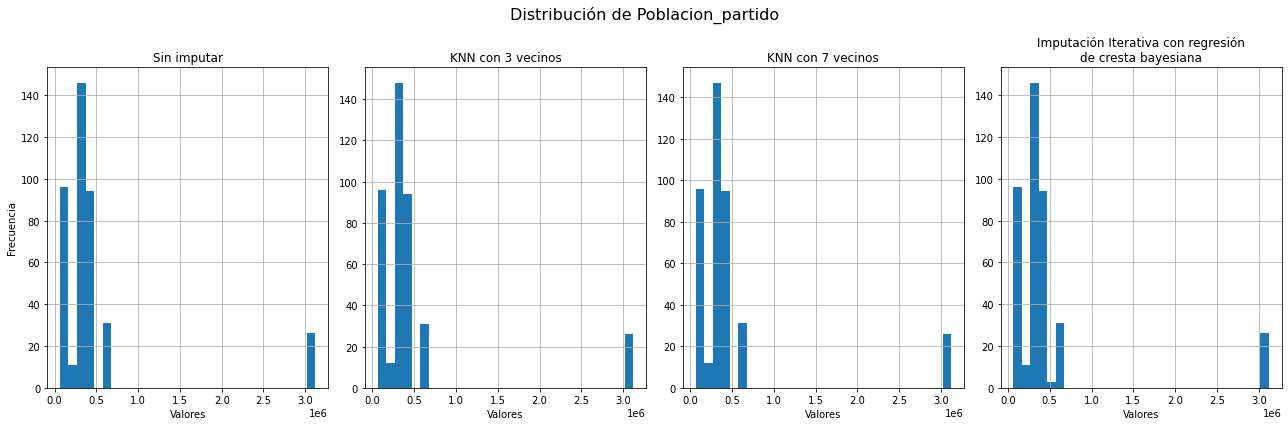

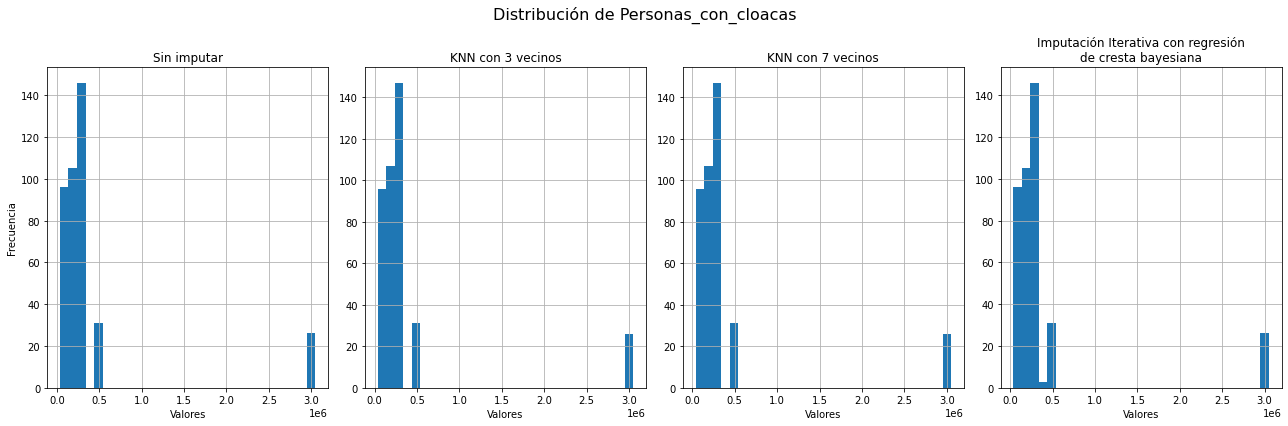

In [35]:
# Visualicemos cuál es la mejor opción para imputar, buscando aquel método que mejor preserve la distribución de los
    # datos
print("Para dataset A")
numerical_imputation_exploration(X_A_train, numerical_cols_A)

Para dataset B


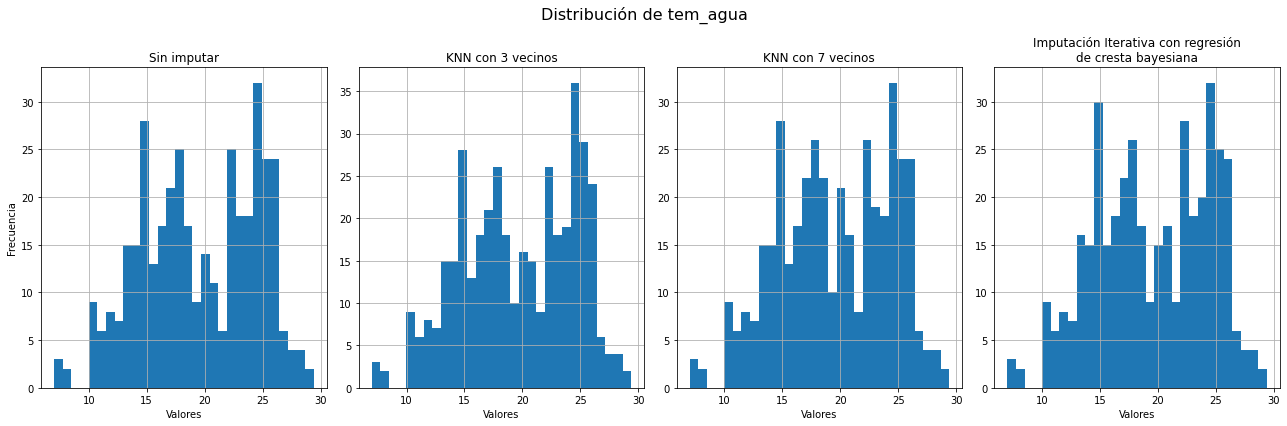

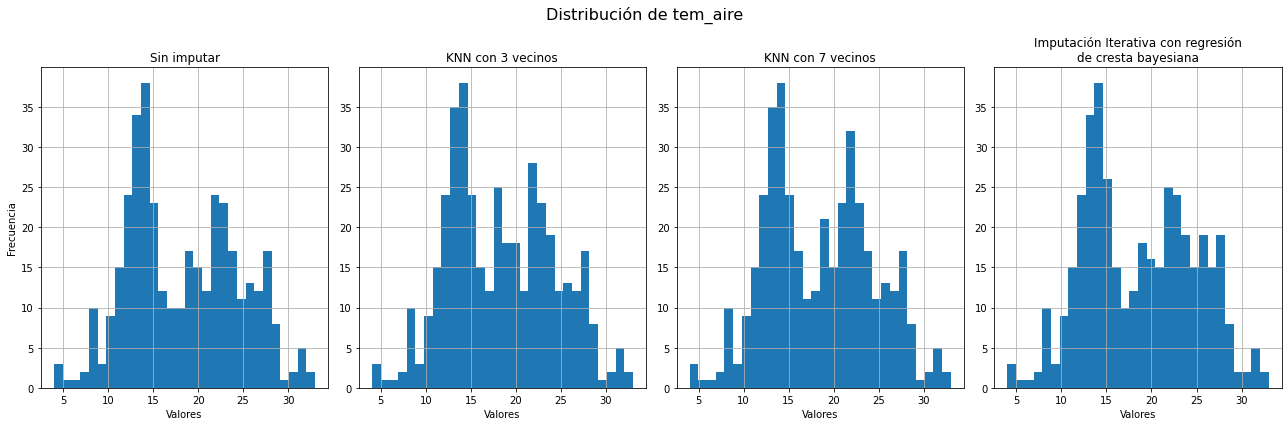

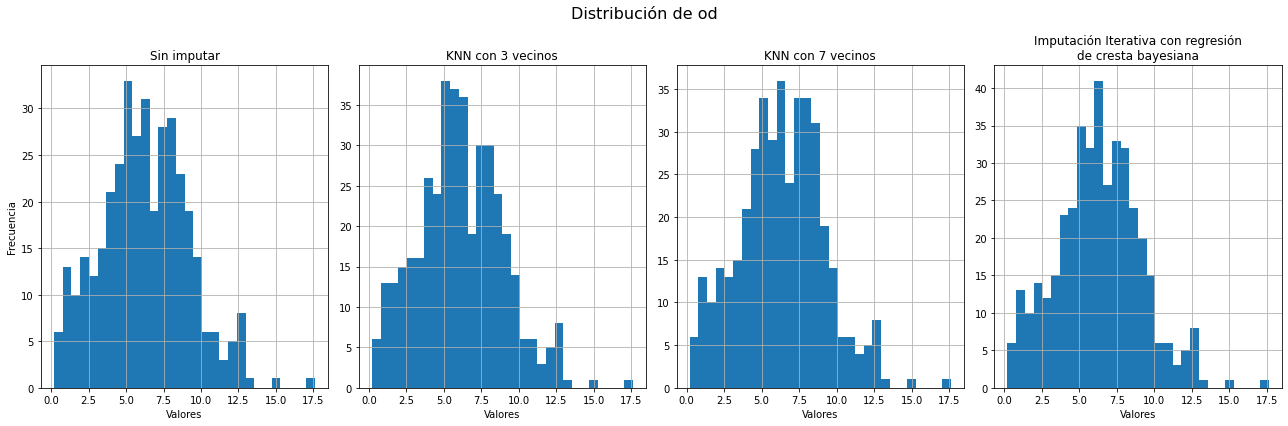

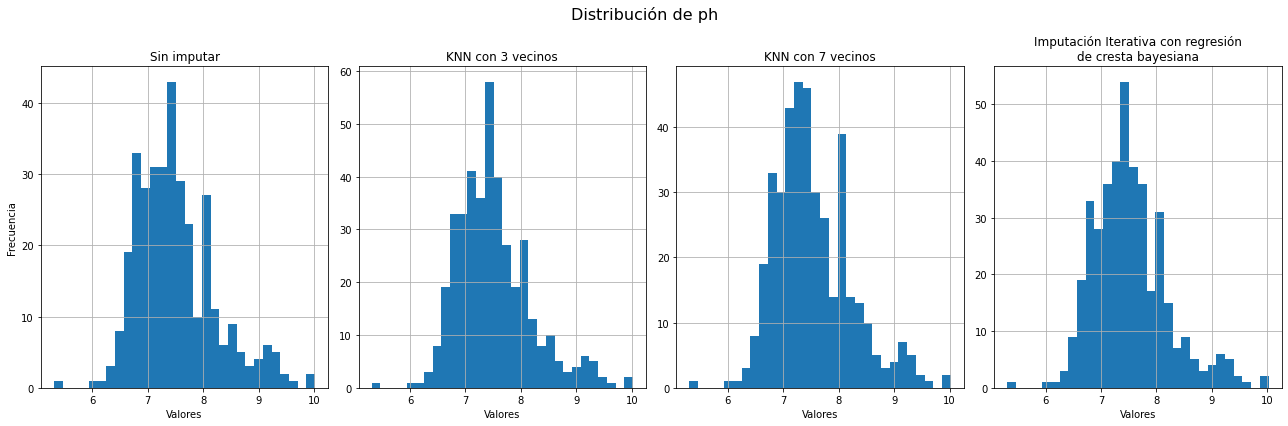

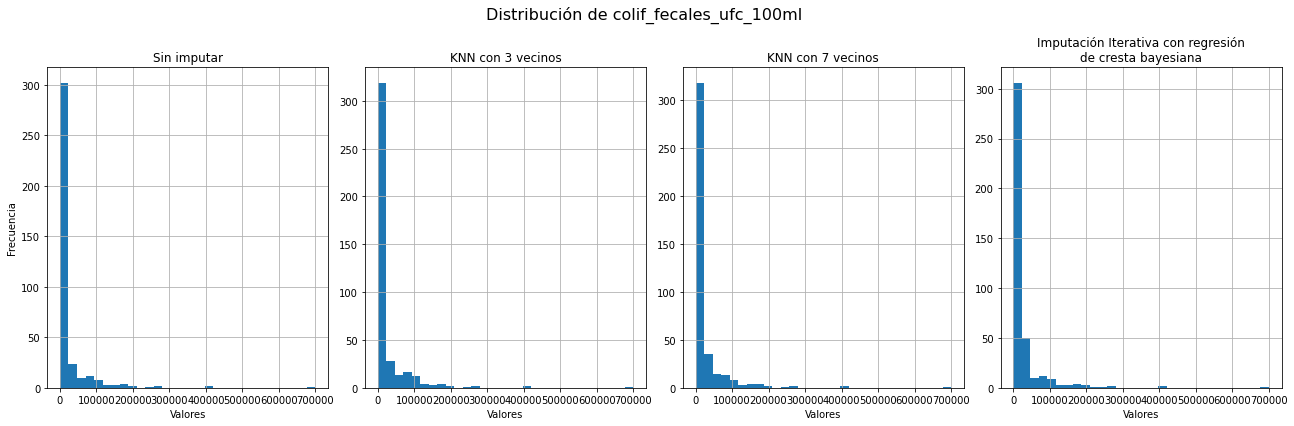

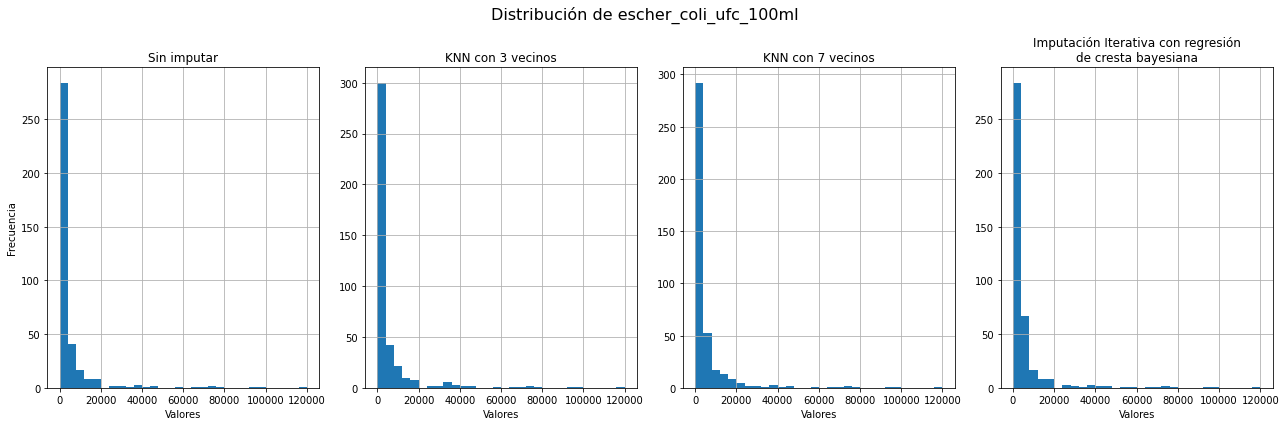

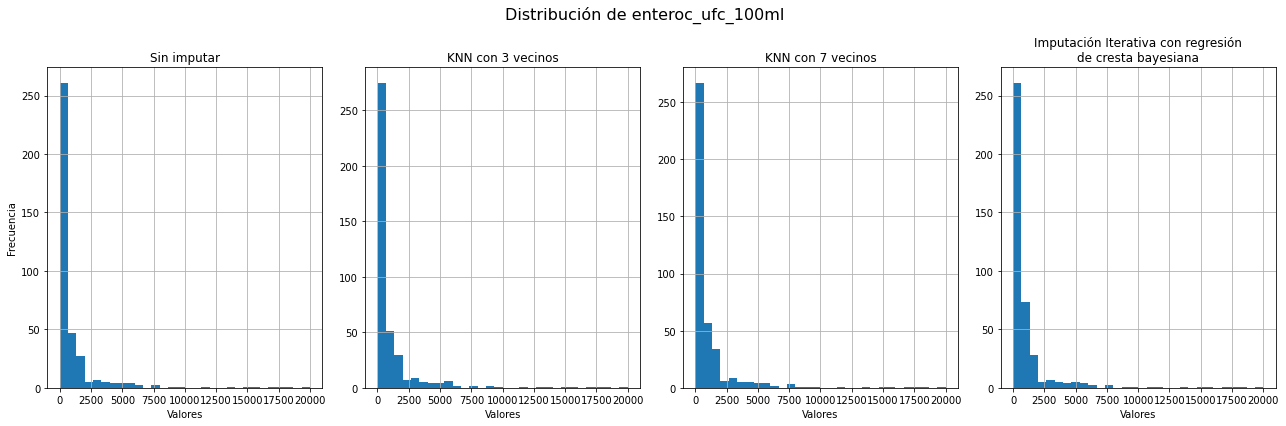

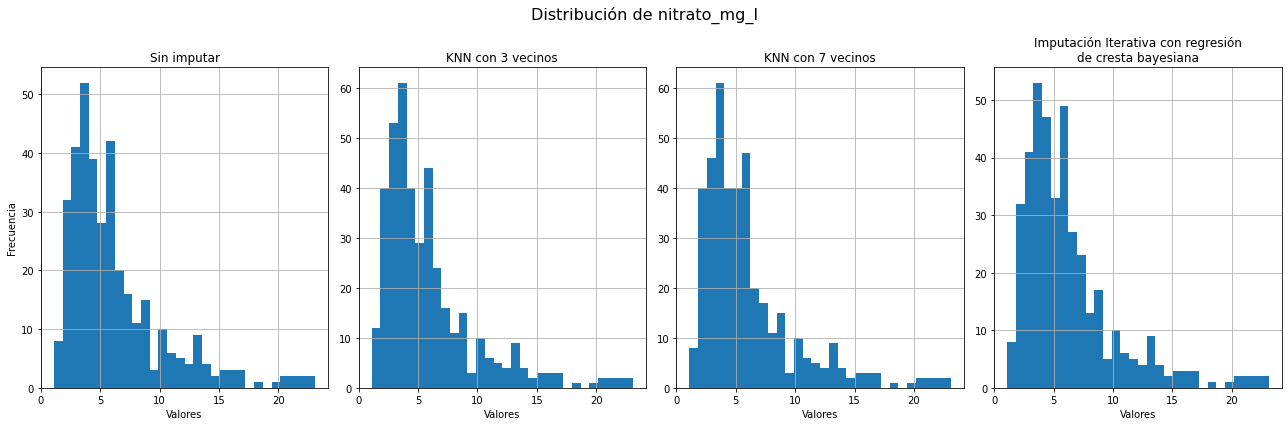

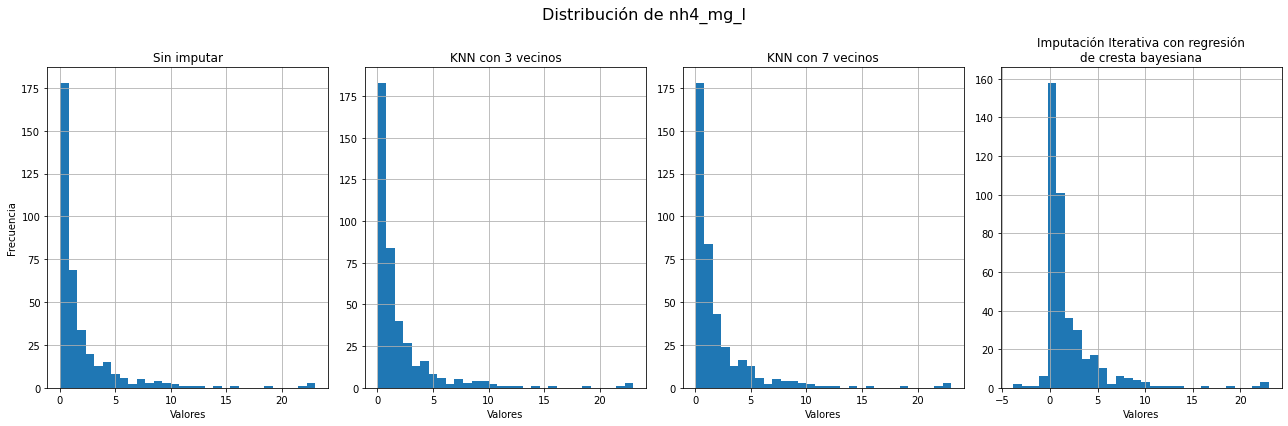

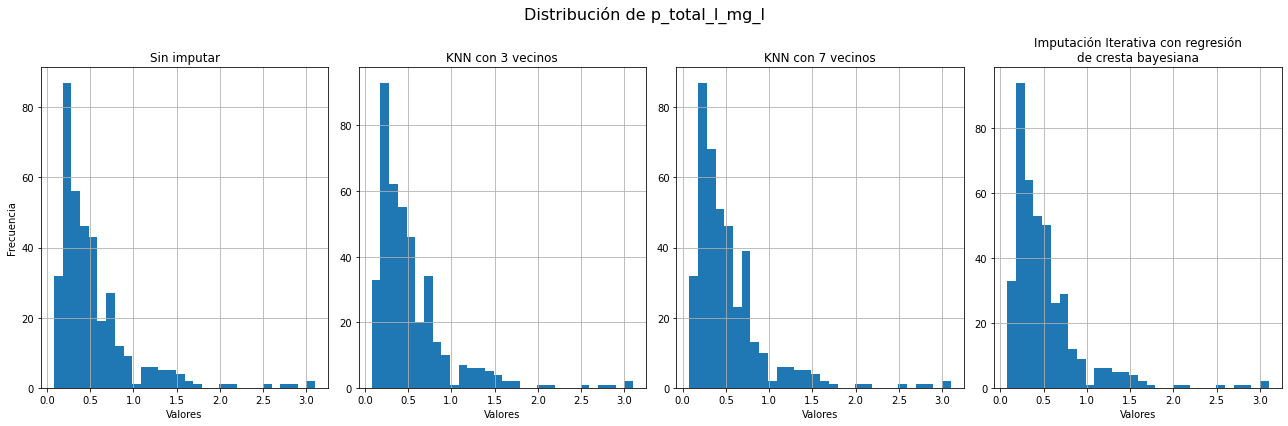

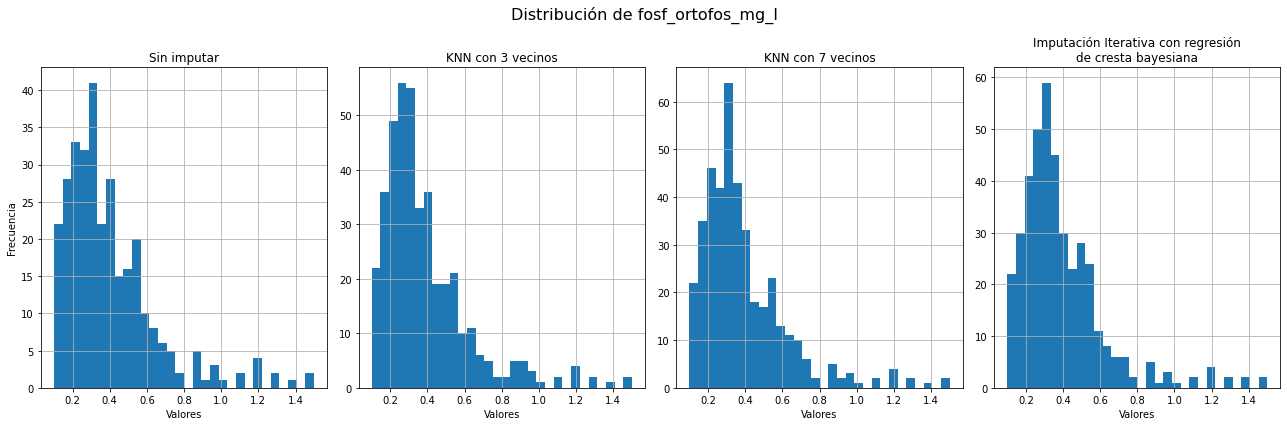

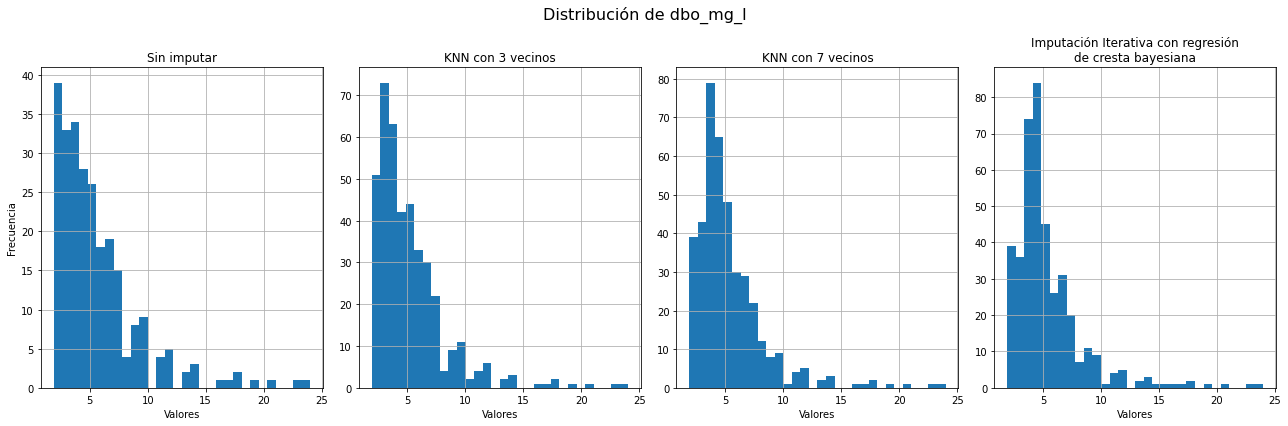

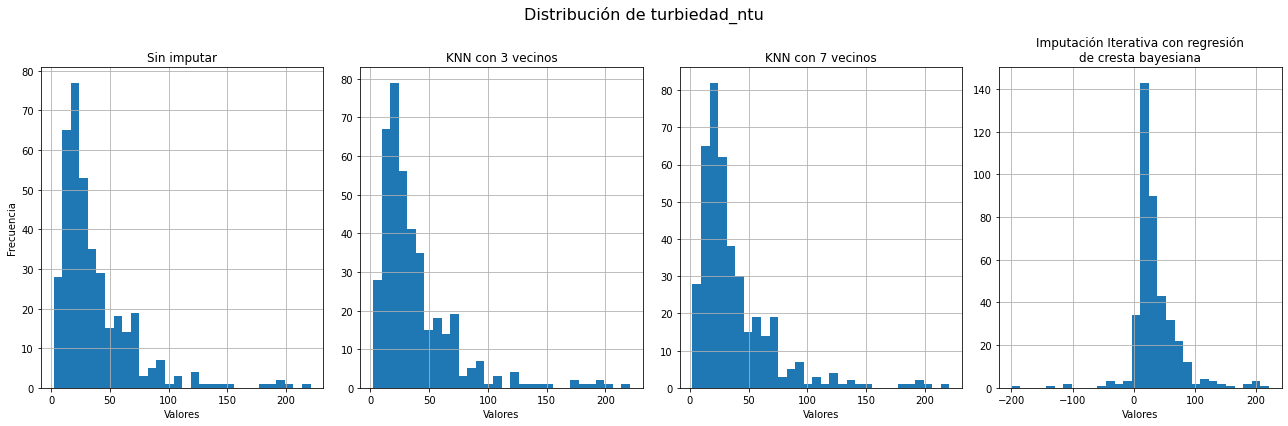

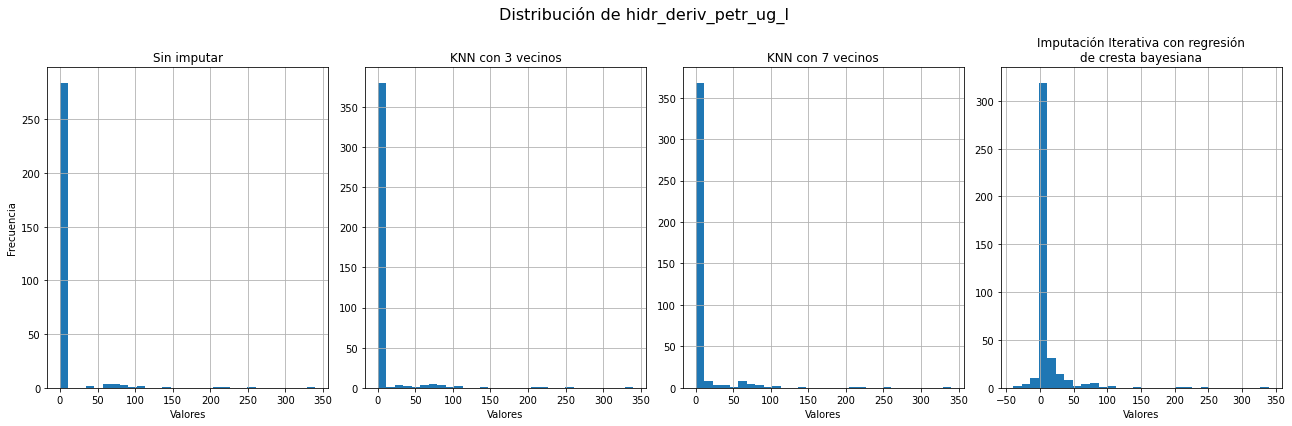

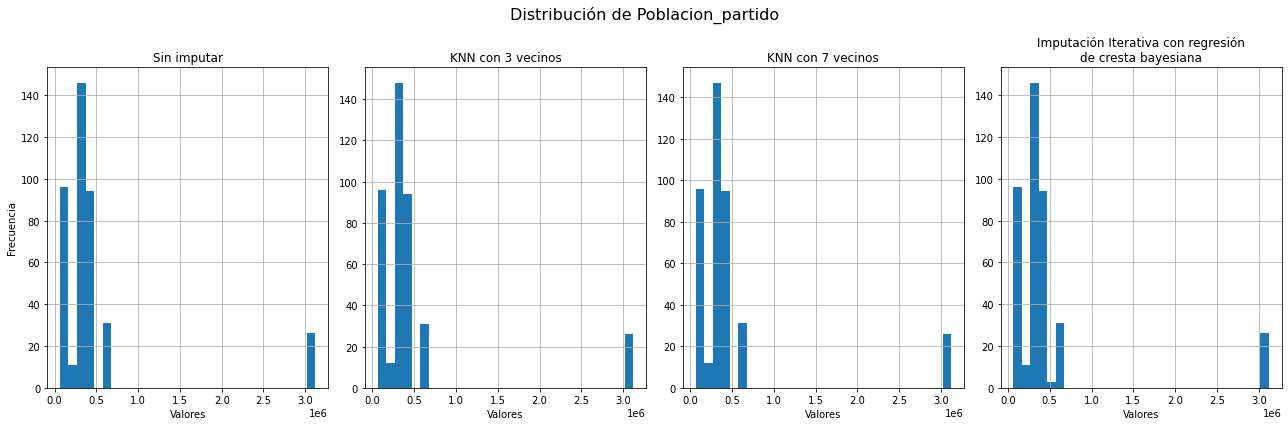

In [36]:
# Visualicemos cuál es la mejor opción para imputar, buscando aquel método que mejor preserve la distribución de los
    # datos
print("Para dataset B")
numerical_imputation_exploration(X_B_train, numerical_cols_B)

Se observa que el imputador bayesiano no tiene un buen desempeño en algunas variables en las que imputa valores negativos cuando deben ser todos no negativos, por lo que esta opción es descartada.

Por otro lado, se aprecia un mejor desempeño de KNN con 7 vecinos, por lo que se opta por esta forma de imputación para los datasets A y B.

In [37]:
# Imputamos variables numéricas en datasets de opción A
knn_num_imputer_7_A = KNNImputer(n_neighbors=7)
X_train_A_num = knn_num_imputer_7_A.fit_transform(X_A_train[numerical_cols_A])
X_test_A_num = knn_num_imputer_7_A.transform(X_A_test[numerical_cols_A])

# Transformamos en df
df_train_A_num = pd.DataFrame(X_train_A_num,
                                    columns=numerical_cols_A,
                                    index=X_A_train.index)
df_test_A_num = pd.DataFrame(X_test_A_num,
                                    columns=numerical_cols_A,
                                    index=X_A_test.index)

# Concatenamos con categóricas
X_train_A_post_num_imp = pd.concat([X_A_train.drop(numerical_cols_A, axis=1), df_train_A_num], axis=1)
X_test_A_post_num_imp = pd.concat([X_A_test.drop(numerical_cols_A, axis=1), df_test_A_num], axis=1)

X_train_A_post_num_imp.to_csv('./A_sets/x_train_post_num_imp.csv', index=False)
X_test_A_post_num_imp.to_csv('./A_sets/x_test_post_num_imp.csv', index=False)

In [38]:
# Imputamos variables numéricas en datasets de opción B
knn_num_imputer_7_B = KNNImputer(n_neighbors=7)
X_train_B_num = knn_num_imputer_7_B.fit_transform(X_B_train[numerical_cols_B])
X_test_B_num = knn_num_imputer_7_B.transform(X_B_test[numerical_cols_B])

# Transformamos en df
df_train_B_num = pd.DataFrame(X_train_B_num,
                                    columns=numerical_cols_B,
                                    index=X_B_train.index)
df_test_B_num = pd.DataFrame(X_test_B_num,
                                    columns=numerical_cols_B,
                                    index=X_B_test.index)

# Concatenamos con categóricas
X_train_B_post_num_imp = pd.concat([X_B_train.drop(numerical_cols_B, axis=1), df_train_B_num], axis=1)
X_test_B_post_num_imp = pd.concat([X_B_test.drop(numerical_cols_B, axis=1), df_test_B_num], axis=1)

X_train_B_post_num_imp.to_csv('./B_sets/x_train_post_num_imp.csv', index=False)
X_test_B_post_num_imp.to_csv('./B_sets/x_test_post_num_imp.csv', index=False)

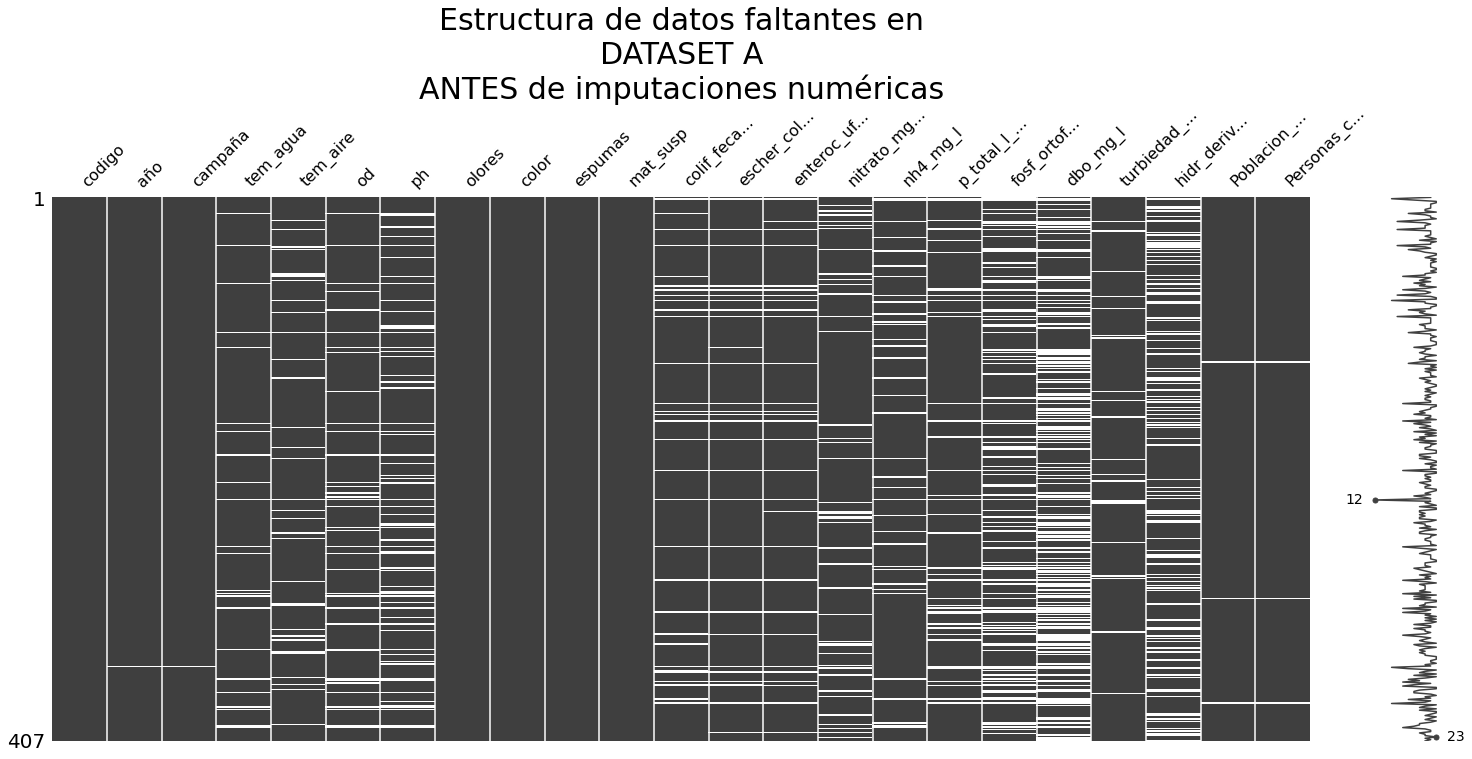

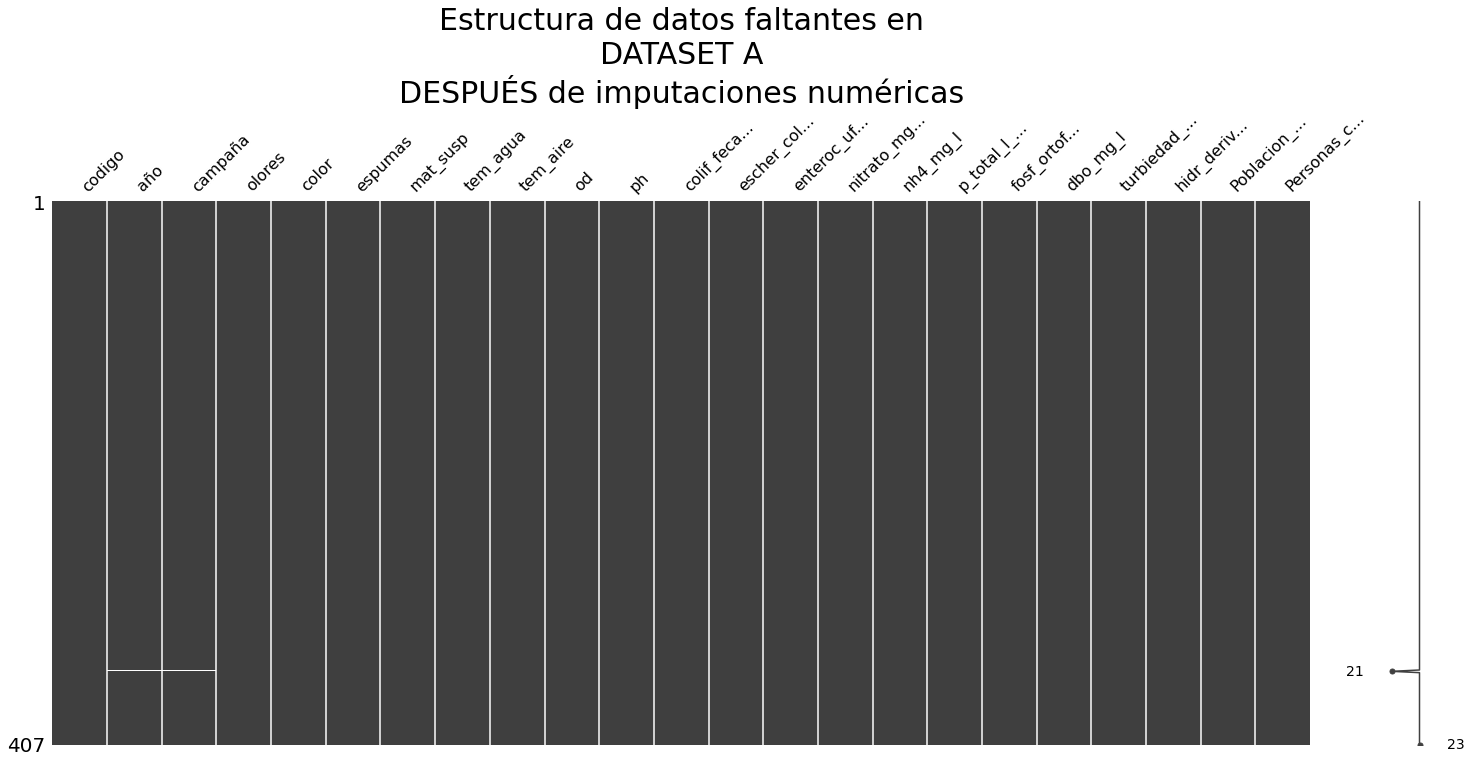

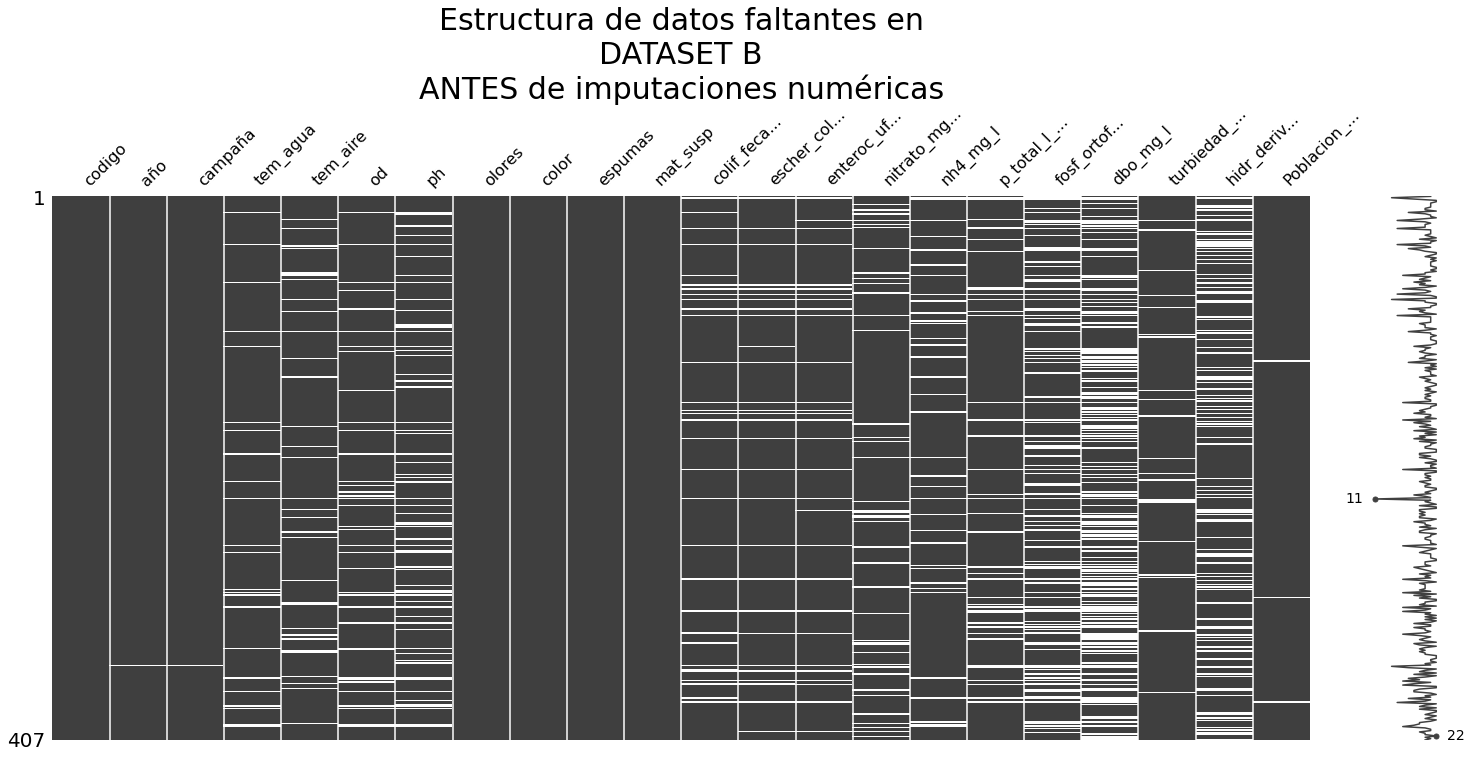

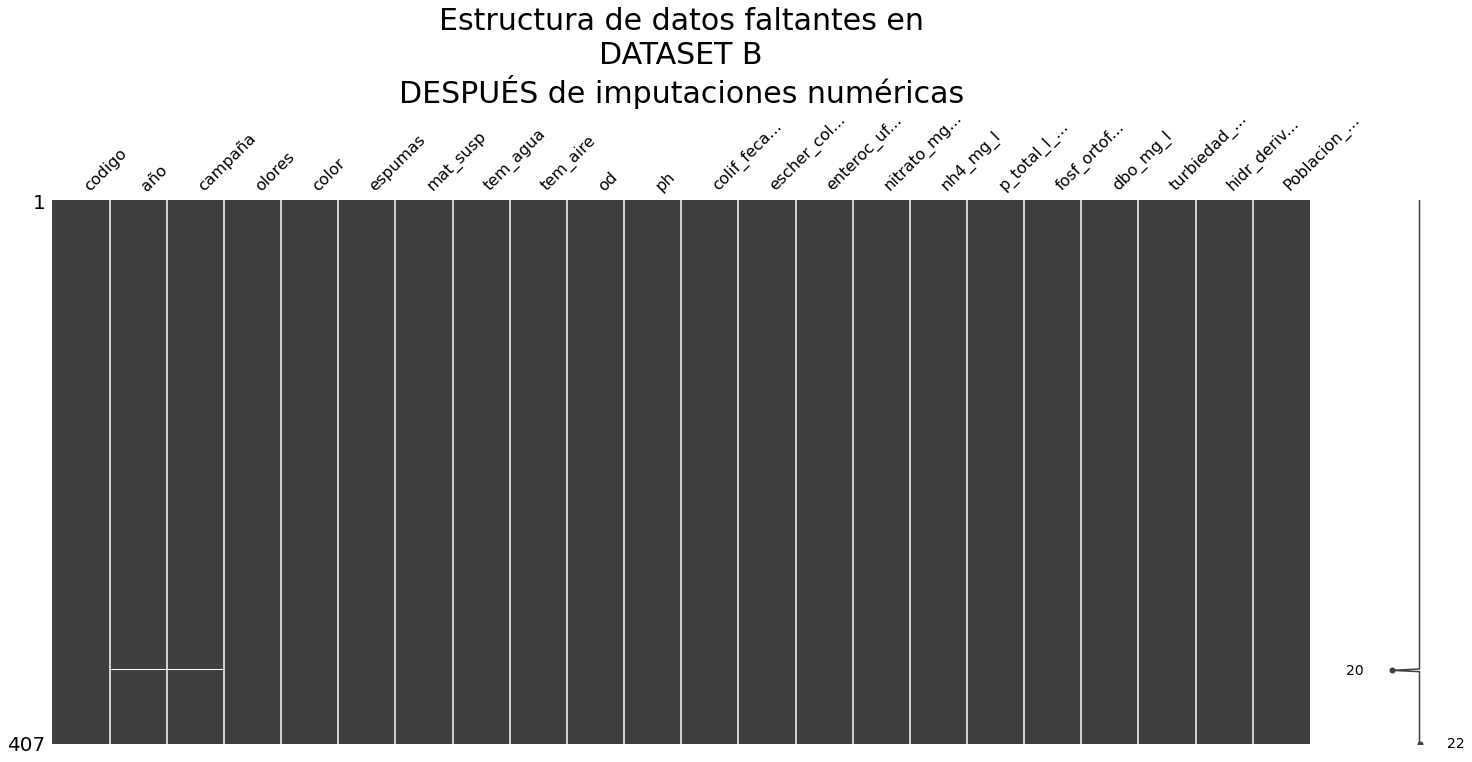

In [39]:
# Veamos estructura de datos faltantes luego de imputar las variables numéricas

### DATASET A
# Dataset A ANTES de imputar numéricas 
missing_matrix(X_A_train, "Estructura de datos faltantes en\nDATASET A\nANTES de imputaciones numéricas")
# Dataset A DESPUÉS de imputar numéricas
missing_matrix(X_train_A_post_num_imp, "Estructura de datos faltantes en\nDATASET A\nDESPUÉS de imputaciones numéricas")

### DATASET B
# Dataset A ANTES de imputar numéricas 
missing_matrix(X_B_train, "Estructura de datos faltantes en\nDATASET B\nANTES de imputaciones numéricas")
# Dataset A DESPUÉS de imputar numéricas
missing_matrix(X_train_B_post_num_imp, "Estructura de datos faltantes en\nDATASET B\nDESPUÉS de imputaciones numéricas")

# 9. Imputación de variables Categóricas

Realizamos una imputación simple para las variables categóricas año y campaña: Imputamos los valores faltantes por el más frecuente. Además, transformamos los datos de año a numéricos para que queden correctamente codificados para su uso en el modelo que se vaya a implementar.

In [40]:
y_A_train = pd.read_csv('./A_sets/y_train_inicial.csv')
y_A_test = pd.read_csv('./A_sets/y_test_inicial.csv')
y_B_train = pd.read_csv('./B_sets/y_train_inicial.csv')
y_B_test = pd.read_csv('./B_sets/y_test_inicial.csv')

X_train_A_post_num_imp = pd.read_csv('./A_sets/x_train_post_num_imp.csv')
X_test_A_post_num_imp = pd.read_csv('./A_sets/x_test_post_num_imp.csv')
X_train_B_post_num_imp = pd.read_csv('./B_sets/x_train_post_num_imp.csv')
X_test_B_post_num_imp = pd.read_csv('./B_sets/x_test_post_num_imp.csv')

categoricas_a_imputar = ['campaña', 'año']

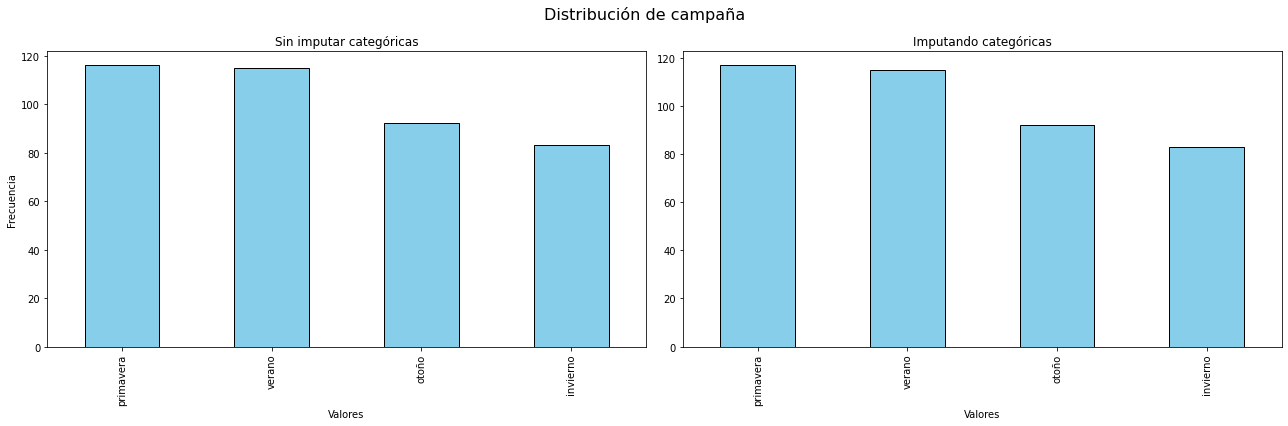

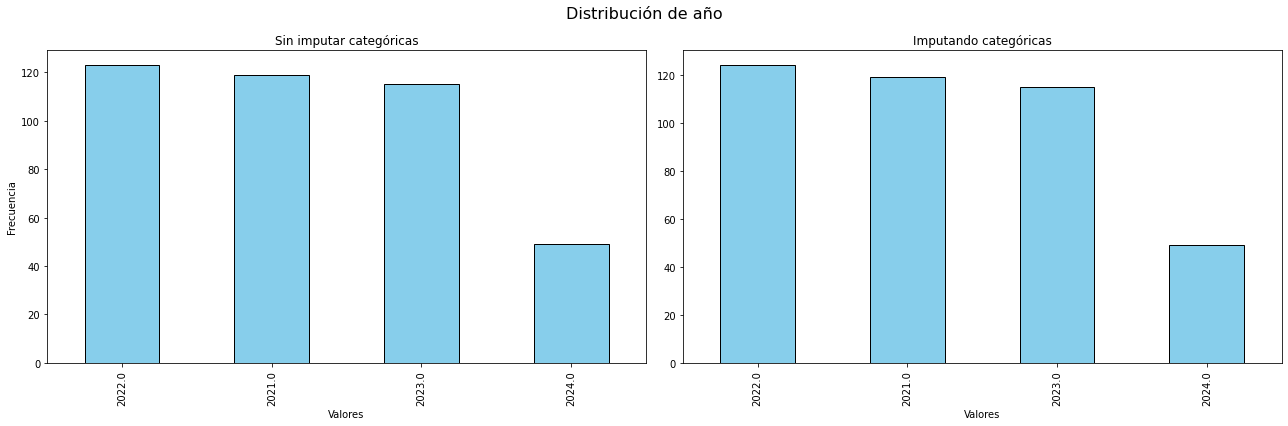

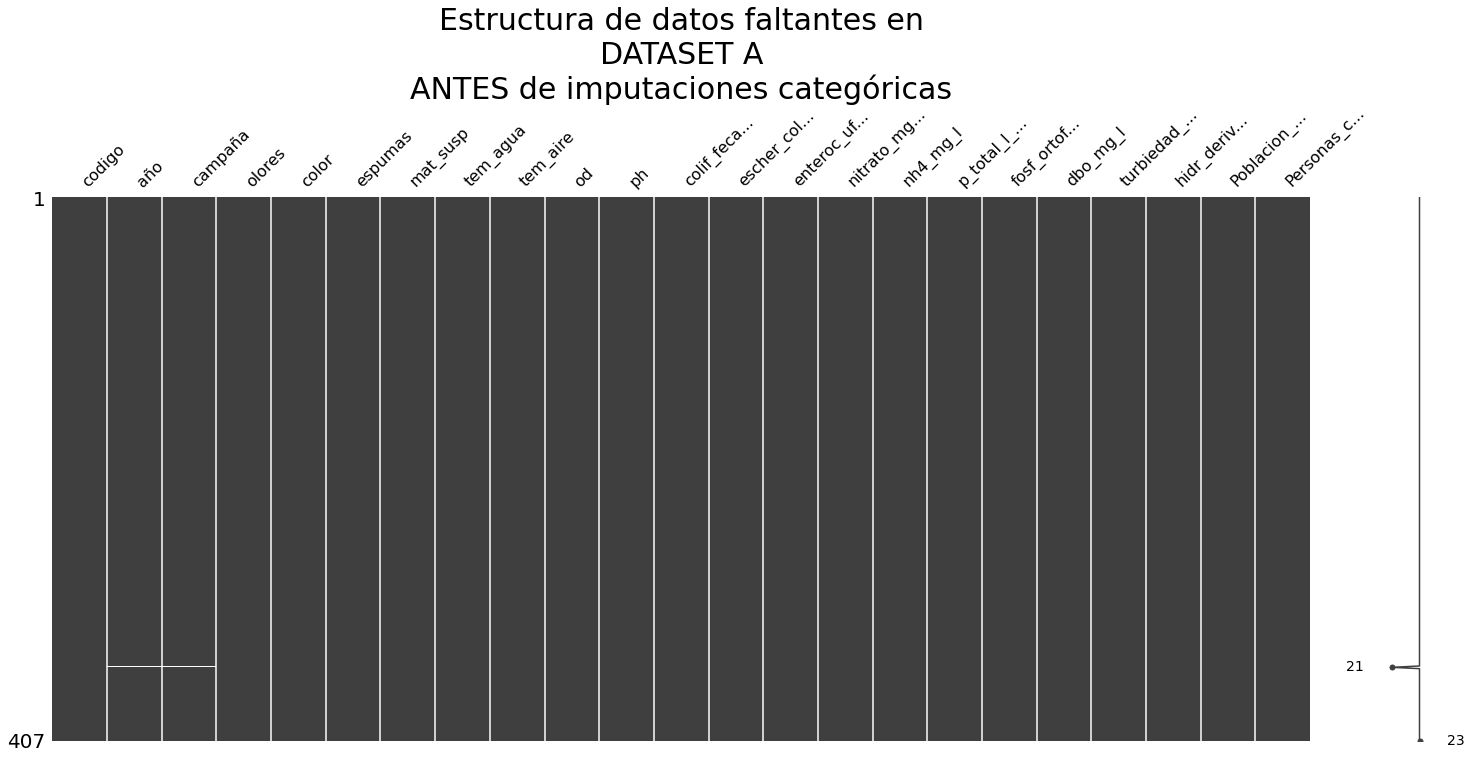

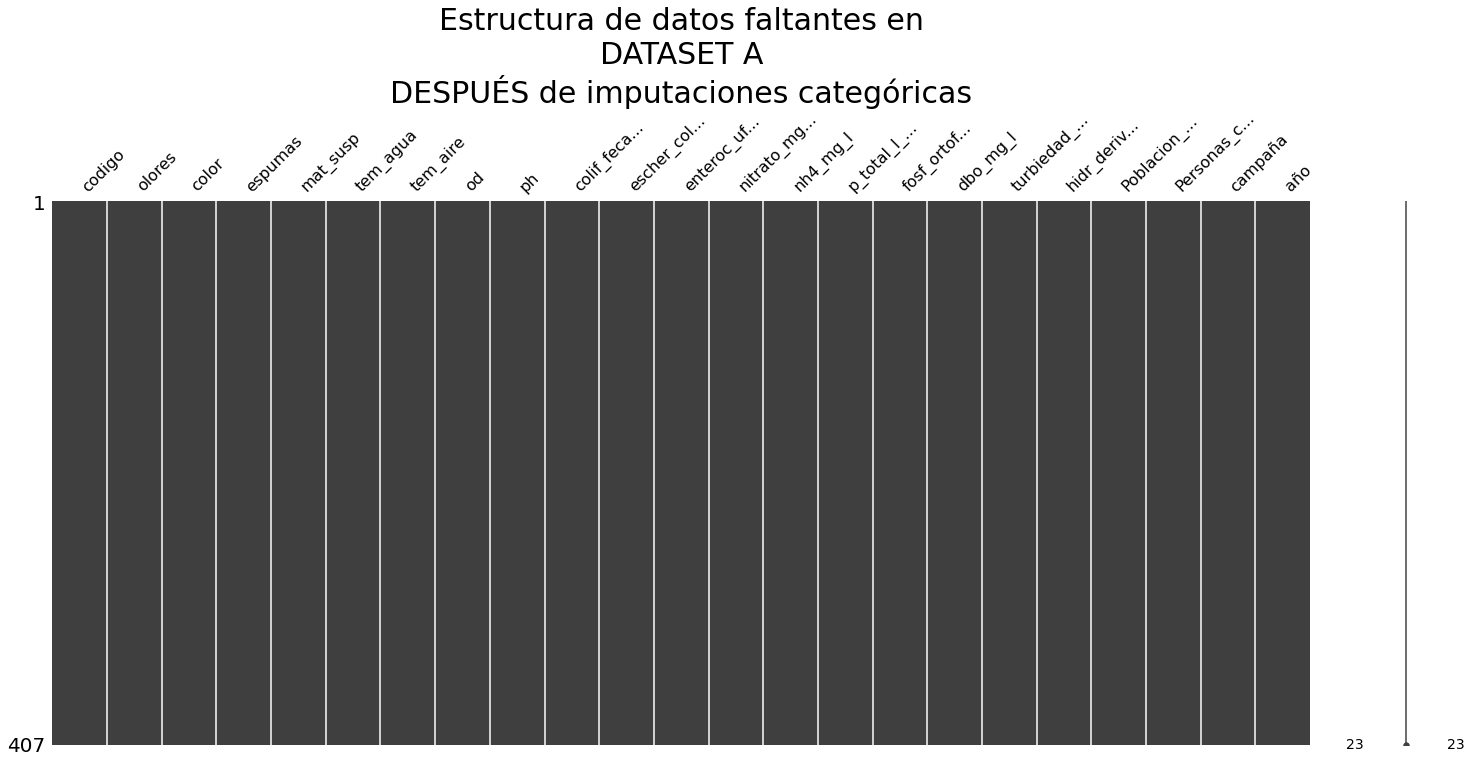

In [41]:
### Imputamos variables categóricas en datasets de opción A
X_train_A_categ_imp, X_test_A_categ_imp = simple_imput_categorical_Values(X_train_A_post_num_imp, X_test_A_post_num_imp, categoricas_a_imputar)

# Transformamos la variable año en numérica
X_train_A_categ_imp['año'] = pd.to_numeric(X_train_A_categ_imp['año'], errors='coerce')
X_test_A_categ_imp['año'] = pd.to_numeric(X_test_A_categ_imp['año'], errors='coerce')

# Exportamos
X_train_A_categ_imp.to_csv('./A_sets/x_train_post_categorical_imp.csv', index=False)
X_test_A_categ_imp.to_csv('./A_sets/x_test_post_categorical_imp.csv', index=False)

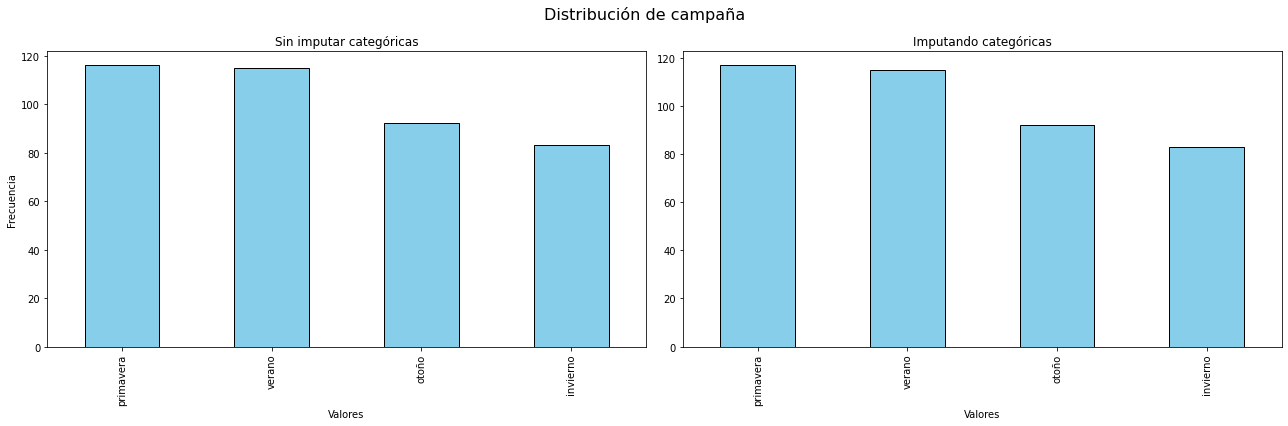

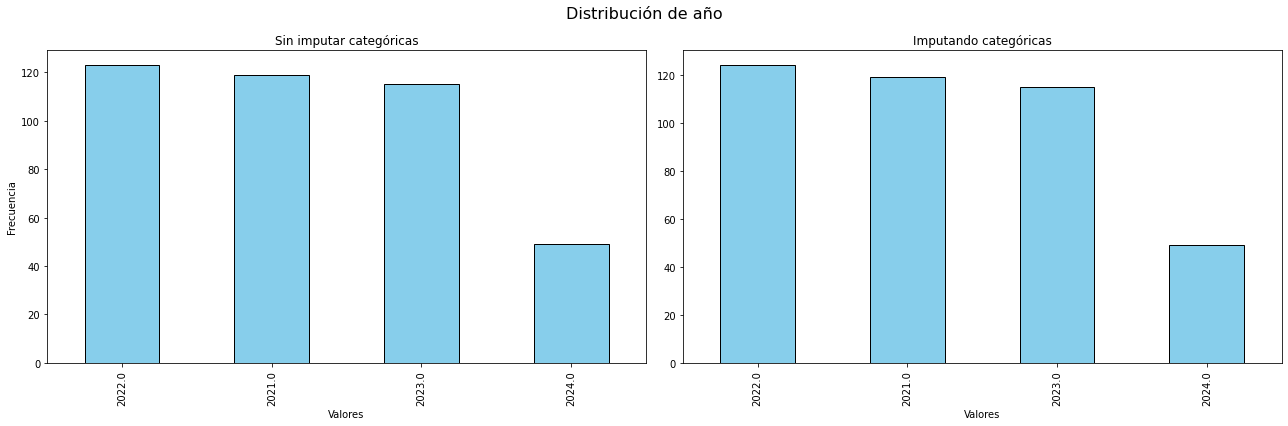

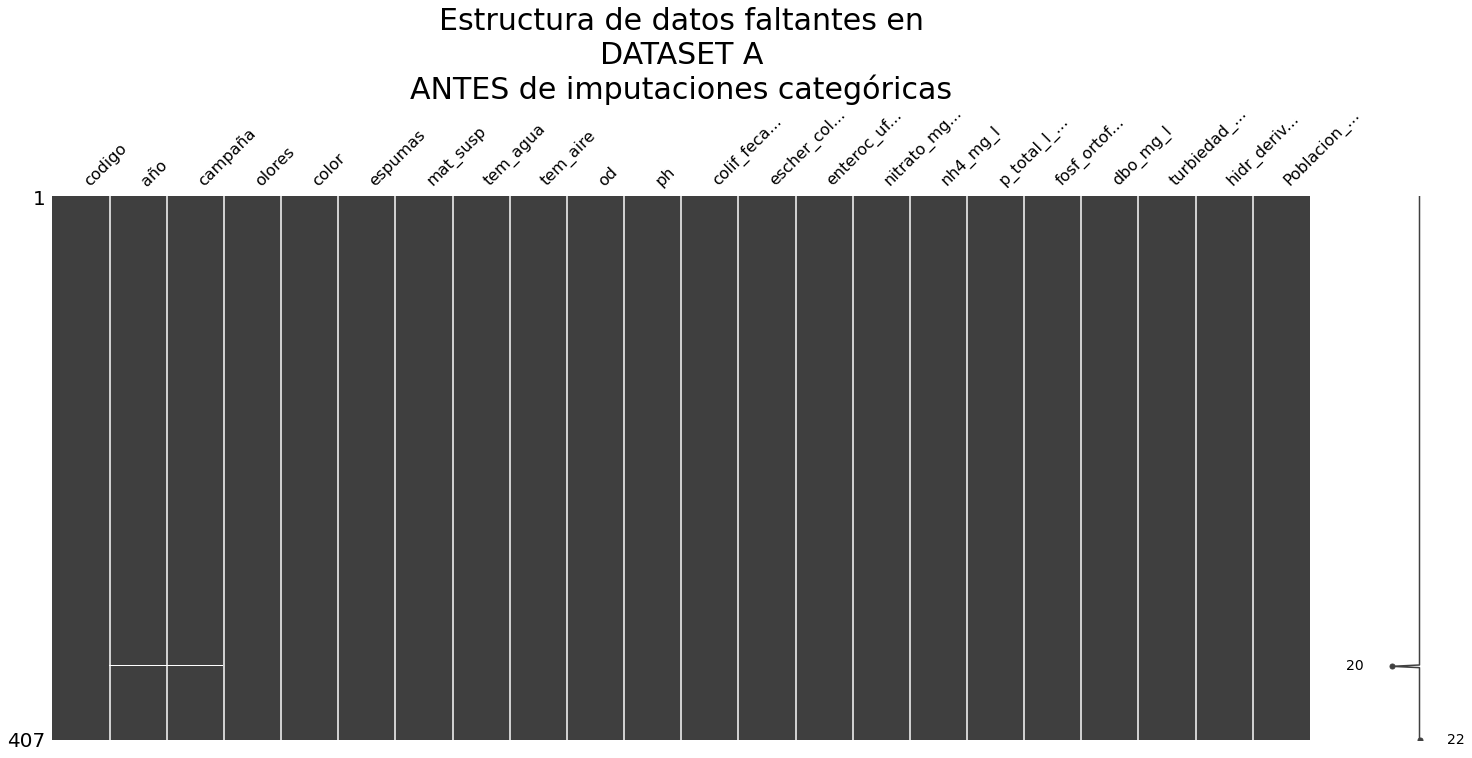

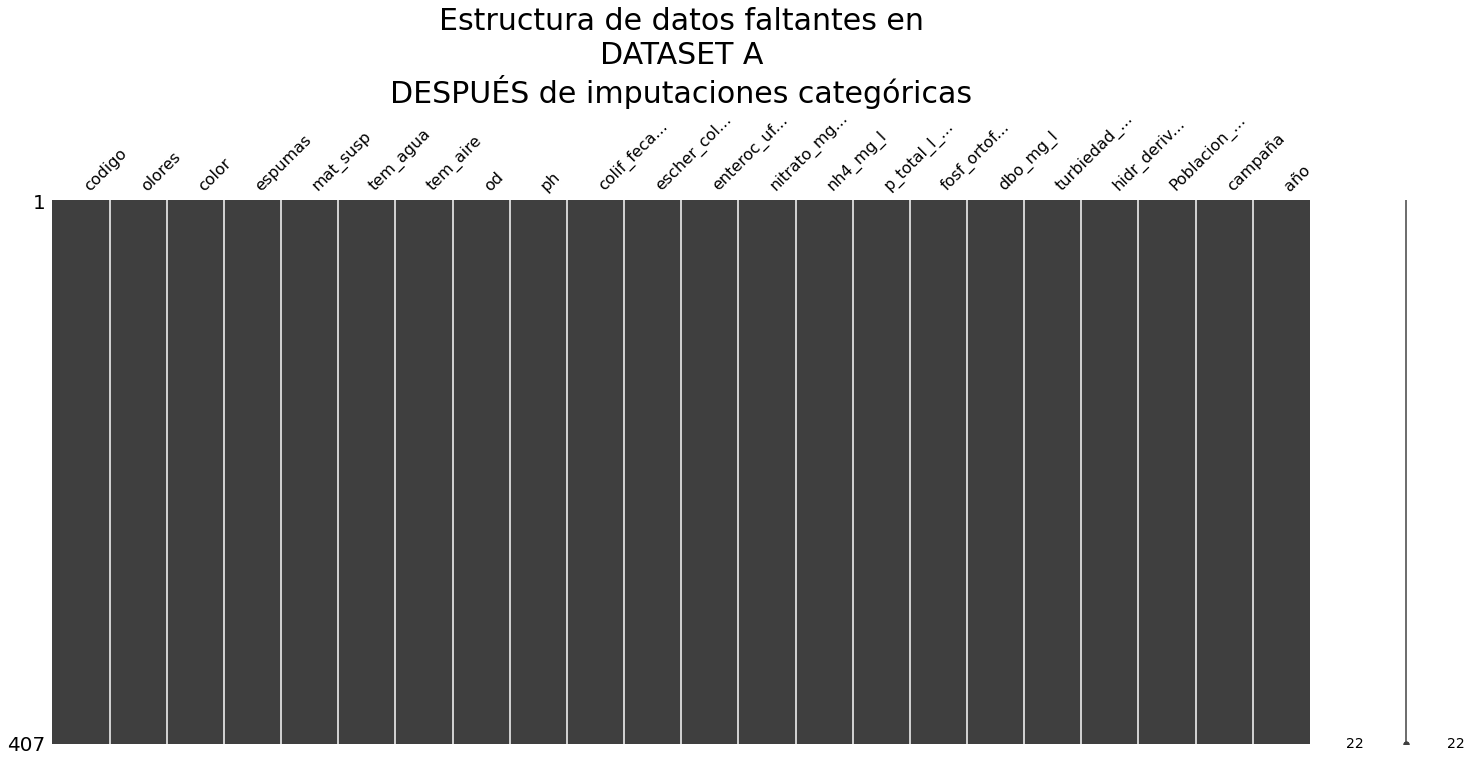

In [42]:
### Imputamos variables categóricas en datasets de opción B
X_train_B_categ_imp, X_test_B_categ_imp = simple_imput_categorical_Values(X_train_B_post_num_imp, X_test_B_post_num_imp, categoricas_a_imputar)

# Transformamos la variable año en numérica
X_train_B_categ_imp['año'] = pd.to_numeric(X_train_B_categ_imp['año'], errors='coerce')
X_test_B_categ_imp['año'] = pd.to_numeric(X_test_B_categ_imp['año'], errors='coerce')

# Exportamos
X_train_B_categ_imp.to_csv('./B_sets/x_train_post_categorical_imp.csv', index=False)
X_test_B_categ_imp.to_csv('./B_sets/x_test_post_categorical_imp.csv', index=False)

# 10. Encoding de Variables Categóricas no Binarias

Codificamos las variables categóricas no binarias (excepto año) -las binarias ya fueron codificadas al inicio de este trabajo-.

La variable codigo es codificada con una codificación ordinal, mientras que la variable campaña con One Hot Encoding.

In [43]:
y_A_train = pd.read_csv('./A_sets/y_train_inicial.csv')
y_A_test = pd.read_csv('./A_sets/y_test_inicial.csv')
y_B_train = pd.read_csv('./B_sets/y_train_inicial.csv')
y_B_test = pd.read_csv('./B_sets/y_test_inicial.csv')

X_train_A_categ_imp = pd.read_csv('./A_sets/x_train_post_categorical_imp.csv')
X_test_A_categ_imp = pd.read_csv('./A_sets/x_test_post_categorical_imp.csv')
X_train_B_categ_imp = pd.read_csv('./B_sets/x_train_post_categorical_imp.csv')
X_test_B_categ_imp = pd.read_csv('./B_sets/x_test_post_categorical_imp.csv')

categ_var_to_OH_encode = ['campaña']
categ_var_to_Ordinal_encode = ['codigo']

In [44]:
# Realizamos One-Hote Encoding de los datasets
print("En dataset A:")
X_train_A_post_cat_encoding, X_test_A_post_cat_encoding, new_columns_names_A = one_hot_encoding(X_train_A_categ_imp, X_test_A_categ_imp, categ_var_to_OH_encode)
print("\nEn dataset B:")
X_train_B_post_cat_encoding, X_test_B_post_cat_encoding, new_columns_names_B = one_hot_encoding(X_train_B_categ_imp, X_test_B_categ_imp, categ_var_to_OH_encode)

En dataset A:

Cantidad de columnas después del One-Hot Encoding: 25

En dataset B:

Cantidad de columnas después del One-Hot Encoding: 24


In [45]:
# Realizamos ordinal encoding en los datasets
print("En dataset A:")
X_train_A_post_cat_encoding, X_test_A_post_cat_encoding = ordinal_encoding(X_train_A_post_cat_encoding, X_test_A_post_cat_encoding, categ_var_to_Ordinal_encode)
print("\nEn dataset B:")
X_train_B_post_cat_encoding, X_test_B_post_cat_encoding = ordinal_encoding(X_train_B_post_cat_encoding, X_test_B_post_cat_encoding, categ_var_to_Ordinal_encode)

En dataset A:
Transforming data by..

Columna 0:
	AC001 -> 0
	AV051 -> 1
	AV052 -> 2
	AV053 -> 3
	AV054 -> 4
	AV055 -> 5
	BS091 -> 6
	BS092 -> 7
	BS093 -> 8
	BS094 -> 9
	BS095 -> 10
	BZ077 -> 11
	BZ078 -> 12
	BZ080 -> 13
	CA041 -> 14
	CA044 -> 15
	CA046 -> 16
	CA047 -> 17
	EN-adic -> 18
	EN-extra -> 19
	EN081 -> 20
	EN082 -> 21
	EN083 -> 22
	EN084 -> 23
	QU061 -> 24
	QU062 -> 25
	QU063 -> 26
	SF015 -> 27
	SI022 -> 28
	SI023 -> 29
	SI024 -> 30
	TI001 -> 31
	TI002 -> 32
	TI003 -> 33
	TI004 -> 34
	TI005 -> 35
	TI006 -> 36
	TI007 -> 37
	TI008 -> 38
	TI009 -> 39
	VL031 -> 40
	VL032 -> 41
	VL033 -> 42


Ordinal encoding completed.

En dataset B:
Transforming data by..

Columna 0:
	AC001 -> 0
	AV051 -> 1
	AV052 -> 2
	AV053 -> 3
	AV054 -> 4
	AV055 -> 5
	BS091 -> 6
	BS092 -> 7
	BS093 -> 8
	BS094 -> 9
	BS095 -> 10
	BZ077 -> 11
	BZ078 -> 12
	BZ080 -> 13
	CA041 -> 14
	CA044 -> 15
	CA046 -> 16
	CA047 -> 17
	EN-adic -> 18
	EN-extra -> 19
	EN081 -> 20
	EN082 -> 21
	EN083 -> 22
	EN084 -> 23
	QU061 -> 

In [46]:
# Veamos una muestra del dataset A para ver cómo quedó:
X_train_A_post_cat_encoding.sample(10)

,olores,color,espumas,mat_susp,tem_agua,tem_aire,od,ph,colif_fecales_ufc_100ml,escher_coli_ufc_100ml,enteroc_ufc_100ml,nitrato_mg_l,nh4_mg_l,p_total_l_mg_l,fosf_ortofos_mg_l,dbo_mg_l,turbiedad_ntu,hidr_deriv_petr_ug_l,Poblacion_partido,Personas_con_cloacas,año,campaña_otoño,campaña_primavera,campaña_verano,codigo
374,0.0,0.0,0.0,0.0,22.000000,22.000000,6.300000,7.390000,1000.000000,900.000000,290.000000,3.100000,1.300000,0.200000,0.345714,3.100000,26.0,0.000000,367554.0,289059.0,2023.0,0.0,1.0,0.0,2.0
34,0.0,0.0,0.0,0.0,8.000000,10.000000,9.700000,8.040000,15000.000000,1500.000000,1000.000000,4.200000,0.200000,0.560000,0.440000,7.000000,29.0,0.000000,100930.0,47630.0,2021.0,0.0,0.0,0.0,9.0
111,0.0,0.0,0.0,0.0,17.000000,17.000000,17.610000,9.980000,20000.000000,1000.000000,800.000000,6.200000,0.711429,0.520000,0.430000,18.000000,60.0,0.000000,358712.0,267760.0,2022.0,1.0,0.0,0.0,13.0
397,1.0,1.0,1.0,0.0,14.400000,8.000000,1.460000,6.800000,100000.000000,10000.000000,400.000000,3.542857,5.700000,0.650000,0.680000,8.600000,16.0,15.714286,446949.0,144834.0,2021.0,0.0,0.0,0.0,35.0
261,0.0,0.0,0.0,0.0,20.942857,25.000000,6.092857,7.878571,6835.714286,3430.000000,841.428571,5.600000,0.049000,0.330000,0.320000,3.100000,45.0,0.000000,63997.0,37375.0,2022.0,0.0,0.0,1.0,19.0
73,0.0,0.0,0.0,0.0,21.600000,19.000000,9.000000,8.600000,34885.714286,14716.571429,1460.428571,3.700000,2.288571,0.702857,0.694286,5.071429,193.0,0.000000,100930.0,47630.0,2024.0,0.0,1.0,0.0,9.0
191,0.0,0.0,0.0,0.0,12.900000,13.000000,8.570000,8.010000,400.000000,100.000000,200.000000,10.600000,1.200000,0.420000,0.260000,2.700000,28.0,0.000000,63997.0,37375.0,2023.0,0.0,0.0,0.0,21.0
5,0.0,0.0,0.0,0.0,18.000000,16.000000,6.600000,6.730000,3.400000,3.400000,800.000000,8.700000,0.930000,0.220000,0.210000,4.942857,14.0,0.000000,282281.0,273863.0,2023.0,1.0,0.0,0.0,42.0
159,0.0,0.0,0.0,0.0,25.500000,26.000000,4.070000,6.920000,5000.000000,4500.000000,350.000000,6.700000,0.660000,0.830000,0.320000,5.142857,29.0,67.142857,282281.0,273863.0,2021.0,0.0,0.0,1.0,42.0
394,1.0,0.0,0.0,0.0,21.000000,18.714286,4.760000,7.650000,200.000000,200.000000,160.000000,3.985714,8.400000,0.200000,0.294286,8.400000,17.0,0.000000,100930.0,47630.0,2023.0,0.0,1.0,0.0,7.0


In [47]:
# Veamos una muestra del dataset B para ver cómo quedó:
X_train_B_post_cat_encoding.sample(10)

,olores,color,espumas,mat_susp,tem_agua,tem_aire,od,ph,colif_fecales_ufc_100ml,escher_coli_ufc_100ml,enteroc_ufc_100ml,nitrato_mg_l,nh4_mg_l,p_total_l_mg_l,fosf_ortofos_mg_l,dbo_mg_l,turbiedad_ntu,hidr_deriv_petr_ug_l,Poblacion_partido,año,campaña_otoño,campaña_primavera,campaña_verano,codigo
333,0.0,0.0,0.0,1.0,24.0,28.0,7.41,6.580000,7000.000000,1600.000000,300.000000,5.400000,0.92,0.410000,0.240000,4.900000,14.000000,0.000000,282281.0,2023.0,0.0,0.0,1.0,40.0
32,0.0,0.0,0.0,1.0,25.4,33.0,6.20,6.900000,2000.000000,1000.000000,58.000000,4.200000,3.30,0.774286,0.140000,4.257143,36.000000,0.000000,446949.0,2021.0,0.0,1.0,0.0,36.0
167,0.0,1.0,0.0,1.0,22.6,23.0,8.50,8.300000,3583.142857,448.571429,101.142857,6.100000,0.10,0.365714,0.422857,6.214286,5.300000,0.000000,633391.0,2024.0,0.0,1.0,0.0,24.0
400,1.0,1.0,1.0,1.0,8.0,12.0,7.20,7.990000,400000.000000,20251.428571,7653.428571,3.728571,8.50,1.200000,0.850000,7.100000,3.300000,0.000000,100930.0,2022.0,1.0,0.0,0.0,10.0
38,0.0,0.0,0.0,0.0,23.0,19.0,6.14,7.000000,3100.000000,2700.000000,340.000000,4.400000,0.40,0.290000,0.334286,3.000000,75.400000,0.000000,297282.0,2024.0,0.0,0.0,1.0,28.0
316,0.0,0.0,0.0,0.0,27.0,27.5,12.65,9.180000,6000.000000,1400.000000,100.000000,5.700000,0.89,0.750000,0.590000,5.757143,70.000000,11.428571,358712.0,2021.0,0.0,1.0,0.0,12.0
229,0.0,0.0,0.0,0.0,15.0,11.0,7.58,7.420000,7000.000000,2000.000000,10.000000,4.400000,0.82,0.730000,0.730000,7.000000,25.514286,70.000000,633391.0,2021.0,1.0,0.0,0.0,26.0
301,0.0,0.0,0.0,1.0,25.9,28.0,8.27,7.240000,7600.000000,1400.000000,1.500000,10.100000,0.75,0.520000,0.360000,4.100000,16.000000,0.000000,282281.0,2023.0,0.0,0.0,1.0,42.0
299,0.0,0.0,0.0,0.0,13.3,13.0,7.50,7.080000,10000.000000,600.000000,300.000000,3.000000,0.44,0.110000,0.110000,4.157143,30.000000,0.000000,446949.0,2022.0,0.0,0.0,0.0,36.0
319,0.0,1.0,0.0,1.0,10.0,12.0,6.67,8.117143,80000.000000,80000.000000,12000.000000,5.200000,1.20,0.735714,0.390000,7.371429,18.200000,0.000000,100930.0,2022.0,0.0,1.0,0.0,10.0


In [48]:
# Exportamos los nuevos datasets
X_train_A_post_cat_encoding.to_csv('./A_sets/x_train_post_cat_encoding.csv', index=False)
X_test_A_post_cat_encoding.to_csv('./A_sets/x_test_post_cat_encoding.csv', index=False)
X_train_B_post_cat_encoding.to_csv('./B_sets/x_train_post_cat_encoding.csv', index=False)
X_test_B_post_cat_encoding.to_csv('./B_sets/x_test_post_cat_encoding.csv', index=False)

# 11. Estandarización y Normalización

Dividimos los dos datasets anteriores en dos versiones, respectivamente, una estandarizada y una normalizada

In [50]:
y_A_train = pd.read_csv('./A_sets/y_train_inicial.csv')
y_A_test = pd.read_csv('./A_sets/y_test_inicial.csv')
y_B_train = pd.read_csv('./B_sets/y_train_inicial.csv')
y_B_test = pd.read_csv('./B_sets/y_test_inicial.csv')

X_train_A_post_cat_encoding = pd.read_csv('./A_sets/x_train_post_cat_encoding.csv')
X_test_A_post_cat_encoding = pd.read_csv('./A_sets/x_test_post_cat_encoding.csv')
X_train_B_post_cat_encoding = pd.read_csv('./B_sets/x_train_post_cat_encoding.csv')
X_test_B_post_cat_encoding = pd.read_csv('./B_sets/x_test_post_cat_encoding.csv')

In [52]:
classifier = VariablesClassification()
orig_num_cols = classifier.numericas

num_A_cols = [col for col in X_train_A_post_cat_encoding.columns if (col in orig_num_cols) and (col != 'año')]
num_B_cols = [col for col in X_train_B_post_cat_encoding.columns if (col in orig_num_cols) and (col != 'año')]

In [56]:
# Aplicamos transformaciones al dataframe A
df_A_train_norm, df_A_test_norm, df_A_train_std, df_A_test_std = normalize_and_standardize(X_train_A_post_cat_encoding, X_test_A_post_cat_encoding, num_A_cols)

In [57]:
# Bplicamos transformaciones al dataframe B
df_B_train_norm, df_B_test_norm, df_B_train_std, df_B_test_std = normalize_and_standardize(X_train_B_post_cat_encoding, X_test_B_post_cat_encoding, num_B_cols)

In [59]:
# Guardamos los dataframes de A
df_A_train_norm.to_csv('./A_sets/x_A_train_norm.csv', index=False)
df_A_test_norm.to_csv('./A_sets/x_A_test_norm.csv', index=False)
df_A_train_std.to_csv('./A_sets/x_A_train_std.csv', index=False)
df_A_test_std.to_csv('./A_sets/x_A_test_std.csv', index=False)

In [60]:
# Guardamos los dataframes de B
df_B_train_norm.to_csv('./B_sets/x_B_train_norm.csv', index=False)
df_B_test_norm.to_csv('./B_sets/x_B_test_norm.csv', index=False)
df_B_train_std.to_csv('./B_sets/x_B_train_std.csv', index=False)
df_B_test_std.to_csv('./B_sets/x_B_test_std.csv', index=False)